# CS390 Project 2: Detection and Segmentation

<button disabled>

**Author:** [Modar Alfadly](http://modar.me) and Hasan Abed Al Kader Hammoud

**Due Date:** 16 Mar 2023 @ 11:59 PM

</button>

In [1]:
# Student Name: David Felipe Alvear Goyes
# KAUST ID: 187594
# Degree: Electrical and Computer engineering
# Major: Autonomous and distributed systems

To setup a conda environment for this project, just run the following commands:

```shell
conda create -n cs323 python=3.9.1 -y
conda activate cs323

conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c conda-forge -y  # install PyTorch 1.7.1
conda install jupyter -y  # to edit this file
conda install matplotlib -y  # for plotting
conda install tqdm -y  # for nice progress bar

pip install jupyter_http_over_ws  # for Google Colab
jupyter serverextension enable --py jupyter_http_over_ws  # Google Colab
```

In the previous project, you learned the basics of building and training regression and classification models in PyTorch. In this project, we will focus more on how to **evaluate** them and choose a suitable **training procedure** for our goals (e.g., data augmentation and loss function). In addition, we will see how we can **construct models** to perform derivative classification tasks; like [detection](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection) and [segmentation](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation).

# Part 0: Introduction

In this project, we will tackle two of the following [computer vision tasks](https://paperswithcode.com/area/computer-vision):

1. **Semantic Segmentation**: Per-Pixel Class Label ([code](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/nnUNet))
1. **Instance Segmentation**: Per-Pixel Object Label ([code](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/MaskRCNN) - [review](https://towardsdatascience.com/single-stage-instance-segmentation-a-review-1eeb66e0cc49))
1. **Classification + Localization**: Bounding Box + Class Label
1. **Object Detection**: List[ Bounding Box + Object Label ] ([code](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD))

In this [notebook](http://bit.ly/dl_for_cv_06), you can find a breakdown for each one. Moreover, you can find examples of these tasks and more using PyTorch in this [repo](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/).

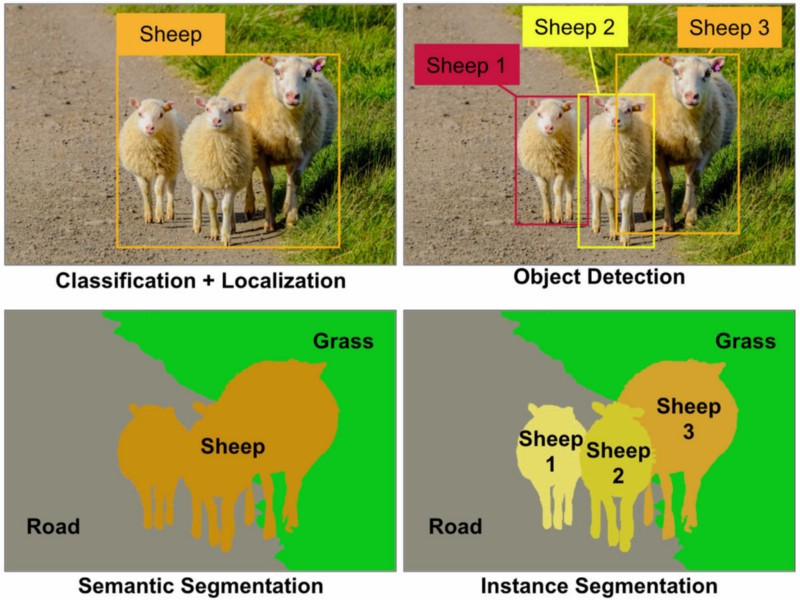

In [2]:
# built-in imports
import enum # For create enumerations
import math 
from pathlib import Path # To work with file paths
from urllib.request import urlopen # Module for open URLs

from tqdm.notebook import tqdm # module for progress bar

# images and plotting
from PIL import Image
from PIL import ImageColor, ImageOps # Image operations

import matplotlib.pyplot as plt
import matplotlib.patches as patches # Create patches on graphs

# scientific computation
import numpy as np

import torch
import torch.nn as nn # for building neural network layers
import torch.nn.functional as F # module for nuilding neural functions
from torch.utils.data import Dataset, DataLoader, random_split # handling data

import torchvision
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF # image transformations
from torchvision.datasets.utils import download_url
from torchvision.datasets.utils import download_and_extract_archive

## Evaluation Metrics

### Loss vs Metric

Before we begin, let's talk about loss functions (for training) and performance metrics (for evaluation). We interpret our goals as performance metrics, such that the better the metric value, the closer the model is to our goal. However, these metrics are not differentiable most of the time and training directly with them is not always feasible. Therefore, we derive surrogate cost functions (losses) that are easier to deal with. They don't necessarily affect the performance metrics directly for a given model. Despite that, we design them to expect that the lower the loss the better the performance and the closer we get to our goal.

<table>
  <thead>
    <td></td><td><b>Loss Function</b></td><td><b>Performance Metric</b></td>
  </thead>
  <tbody>
    <tr>
      <td><b><a href="https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914">Regression</a></b></td>
      <td>
        <ul>
          <li>L1: Mean Absolute Error (MAE)</li>
          <li>L2: Mean Squared Error (MSE)</li>
          <li>... <a href="https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0">etc</a></li>
        </ul>
      </td>
      <td>
        <ul>
          Usually, the same as the loss function <br/>
          or some high-level objective.
        </ul>
      </td>
    </tr>
    <tr>
      <td><b><a href="https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/">Classification</a></b></td>
      <td>
        <ul>
          <li>Hinge Loss (with SVMs)</li>
          <li>Softmax Cross-Entropy (XE)</li>
          <li>... <a href="https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0">etc</a></li>
        </ul>
      </td>
      <td>
        <b><a href="https://en.wikipedia.org/wiki/Confusion_matrix">Confusion Matrix</a></b>:
        <ul>
          <li>Accuracy</li>
          <li>Precision</li>
          <li>Recall</li>
          <li>IoU</li>
          <li>... <a href="https://www.mathworks.com/help/vision/ref/semanticsegmentationmetrics.html">etc</a></li>
        </ul>
      </td>
    </tr>
  </tbody>
</table>

*Note*: This is just a short list of examples. Things like time and space efficiency can also be considered as performance metrics.

If you recall, for the classification task in Project 1, we picked the loss to be the **softmax cross-entropy loss** and the performance metric to be the **accuracy** (we computed it as the ratio of the correctly classified samples over the total number of samples).

### Confusion Matrix

Most of the performance metrics for classification are derived from the confusion matrix. Let's take a dataset that contains $110$ images {$50$ cat images, $40$ dog images, and $20$ horse images}. The unnormalized confusion matrix of a classifier might look like this:

| \     | Cat | Dog | Horse |
| ----- | --- | --- | ----- |
| Cat   | 42  | 8   | 0     |
| Dog   | 6   | 30  | 4     |
| Horse | 1   | 2   | 17    |

The rows are the **actual** class and the columns are the **predicted** class (e.g., there are $6$ dog images the model thought they were that of cats). To get the accuracy as in Project 1, we can just sum the diagonal and divide by the total $\frac{42+30+17}{110} \approx 80.91\%$. We will see later that this is actually called weighted recall. In fact, it is very [common](https://www.mathworks.com/help/releases/R2020a/vision/ref/evaluatesemanticsegmentation.html) to find recall referred to as accuracy although they are different metrics.

### Table of Confusion

The $2 \times 2$ confusion matrix for binary classification is called the table of confusion. However, we give every value a meaningful name:

| \       | Cat                 | Not Cat             |
|---------|---------------------|---------------------|
| Cat     | True Positive (TP)  | False Negative (FN) |
| Not Cat | False Positive (FP) | True Negative (TN)  |

Notice that we can summarize any $N \times N$ confusion matrix as $N$ confusion tables (i.e., table for every class "[one-vs-rest](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)"). To compute them for a class, just sum the rows and columns of the other classes (consider them as "rest" class).

In [3]:
# build a confusion matrix
classes = ('Cat', 'Dog', 'Horse')
cm = torch.FloatTensor([
    [42, 8, 0],
    [6, 30, 4],
    [1, 2, 17],
])

# extract the confusion tables
confusion = []
for i, class_name in enumerate(classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    confusion.append((tp, fn, fp, tn))

    print(class_name)
    print(f'| TP = {tp:2.0f} | FN = {fn:2.0f} |')
    print(f'| FP = {fp:2.0f} | TN = {tn:2.0f} |\n')

Cat
| TP = 42 | FN =  8 |
| FP =  7 | TN = 53 |

Dog
| TP = 30 | FN = 10 |
| FP = 10 | TN = 60 |

Horse
| TP = 17 | FN =  3 |
| FP =  4 | TN = 86 |



Working with this representation has many advantages. It contains the most relevant information for evaluation from the $N \times N$ matrix, which can be stored in an $N \times 4$ matrix. This is a good saving especially when $N > 4$. In fact, we can compress this even further to $(N \times 3) + 1$. The trick is to notice that `Total = TP + FN + FP + TN` is the same for all tables (e.g., $110$ is the total number of images). For every class, we need to only remember the first three values `{TP, FN, FP}` and the fourth value can be easily computed as `TN = Total - (TP + FN + FP)`.

Another advantage, is the ability to derive more [meaningful metrics](https://en.wikipedia.org/wiki/Confusion_matrix) like [recall (sensitivity) and precision](https://en.wikipedia.org/wiki/Precision_and_recall).

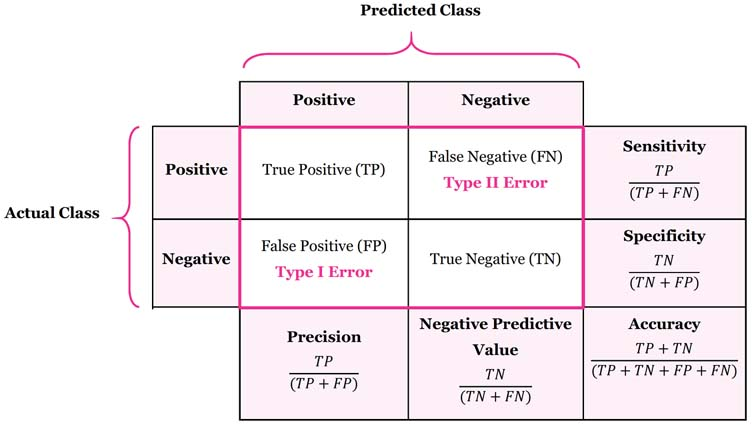

### Working Example

| \     | Cat | Dog | Horse |
| ----- | --- | --- | ----- |
| Cat   | 42  | 8   | 0     |
| Dog   | 6   | 30  | 4     |
| Horse | 1   | 2   | 17    |

---

<table>
<tbody>
<tr>
<td>

| \       | Cat | Not Cat |
|---------|-----|---------|
| Cat     | 42  | 8       |
| Not Cat | 7   | 53      |

</td>
<td>|<br/>|<br/>|<br/>|<br/>|<br/>|</td>
<td>

| \       | Dog | Not Dog |
|---------|-----|---------|
| Dog     | 30  | 10      |
| Not Dog | 10  | 60      |

</td>
<td>|<br/>|<br/>|<br/>|<br/>|<br/>|</td>
<td>

| \         | Horse | Not Horse |
|-----------|-------|-----------|
| Horse     | 17    | 3         |
| Not Horse | 4     | 86        |

</td>
</tr>
</tbody>
</table>

These metrics are defined on class level (i.e., we can compute them for every class given their confusion matrices).

| \     | Accuracy $\frac{\text{TP}+\text{TN}}{\text{Total}}$ | Recall $\frac{\text{TP}}{\text{TP}+\text{FN}}$ | Precision $\frac{\text{TP}}{\text{TP}+\text{FP}}$ |
|-------|----------|--------|-----------|
| **Cat**   | $\frac{42 + 53}{110} \approx 86.36\%$ | $\frac{42}{42 + 8} = 84\%$ | $\frac{42}{42 + 7} \approx 85.71\%$ |
| **Dog**   | $\frac{30 + 60}{110} \approx 81.82\%$ | $\frac{30}{30 + 10} = 75\%$ | $\frac{30}{30 + 10} = 75\%$ |
| **Horse** | $\frac{17 + 86}{110} \approx 93.64\%$ | $\frac{17}{17 + 3} = 85\%$ | $\frac{17}{17 + 4} \approx 80.95\%$ |

- **Accuracy**: correctly classified samples **with respect to the class** ($\text{TP} + \text{TN}$) *over* total number of samples ($\text{TP} + \text{FN} + \text{FP} + \text{TN}$)
- **Recall**: correctly classified samples **in the class** ($\text{TP}$) *over* total number of samples **in the class** ($\text{TP} + \text{FN}$)
- **Precision**: correctly classified samples **in the class** ($\text{TP}$) *over* total number of samples **predicted to be in the class** ($\text{TP} + \text{FP}$)

To help you get a feeling of the differences between these metrics, consider the scenarios were a model classifies:

- everything as Cat regardless of the input; it will have $100\%$ cat recall, but $\frac{50}{110}$ cat accuracy and precision
- everything as Dog except for a single cat image as Cat; it will have $100\%$ cat precision, $\frac{1 + 60}{110}$ cat accuracy, and $\frac{1}{1 + 49}$ cat recall
- every cat image as Cat and anything else as Horse; it will have $100\%$ cat accuracy, recall, and precision

In [4]:
metrics = []
print(' ' * 5, 'Accuracy  Recall  Precision')
perc = lambda x: f' {float(x) * 100:.2f}% '
for i, class_name in enumerate(classes):
    tp, fn, fp, tn = confusion[i]

    accuracy = (tp + tn) / (tp + fn + fp + tn)
    recall =  tp / (tp + fn)
    precision = tp / (tp + fp)
    metrics.append((accuracy, recall, precision))

    print(classes[i].rjust(5), *map(perc, metrics[-1]))

      Accuracy  Recall  Precision
  Cat  86.36%   84.00%   85.71% 
  Dog  81.82%   75.00%   75.00% 
Horse  93.64%   85.00%   80.95% 


To get a single value for all classes we can just compute the mean or use a weighted sum; a [convex combination](https://en.wikipedia.org/wiki/Convex_combination). A common choice for the weights is the frequency $= \frac{\text{TP}+\text{FN}}{\text{Total}}$ of every class in the dataset (e.g., for cats $ = \frac{42 + 8}{110}$). This implies, if we have more cats than dogs in the dataset, a model that is better in classifying cats would be considered better than a model that is equally good on both cats and dogs.

Let's do one example in detail and show the rest of the results in a table:

- Mean accuracy $= \frac{1}{3}(86.36\%+81.82\%+93.64\%) \approx 87.27\%$
- Weighted accuracy $= \frac{42 + 8}{110}86.36\%+\frac{30 + 10}{110}81.82\%+\frac{17 + 3}{110}93.64\% \approx 86.03\%$


| \        | Accuracy | Recall | Precision |
|----------|----------|--------|-----------|
| Mean     | $87.27\%$ | $81.33\%$ | $80.56\%$ |
| Weighted | $86.03\%$ | $80.91\%$ | $80.95\%$ |

In [5]:
accuracy, precision, recall = zip(*metrics)
frequency = list(map(lambda x: (x[0] + x[1]) / sum(x), confusion))

mean = lambda metric: sum(metric) / len(metric)
weighted = lambda metric: sum(f * m for m, f in zip(metric, frequency))

print(' ' * 8, 'Accuracy  Recall  Precision')
print('    Mean', *map(lambda x: perc(mean(x)), zip(*metrics)))
print('Weighted', *map(lambda x: perc(weighted(x)), zip(*metrics)))

         Accuracy  Recall  Precision
    Mean  87.27%   81.33%   80.56% 
Weighted  86.03%   80.91%   80.95% 


Pick the metric that is closest to your goal or combine different metrics if that is what you want (e.g., $F_1$ Score $= 2\frac{\text{Precision}\cdot\text{recall}}{\text{Precision}+\text{recall}}$). You will need to [change your training procedure](https://www.youtube.com/watch?v=W5meQnGACGo&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=68) to optimize for the chosen metric. Because you cannot use it directly, you will have to resort to [other tricks](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler). For example, [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) accepts an optional weight tensor for every class. If you don't supply this argument, the metric you are optimizing for is going to be weighted by the class frequency (i.e., more data will be seen in training from the most frequent classes). If your goal is to optimize for the mean instead, you will have to provide appropriate weights to [balance them](https://datascience.stackexchange.com/a/48374).

See this example showing how `F.cross_entropy()` and `nn.CrossEntropyLoss()` compute the loss when we provide per-class weights:

In [6]:
batch_size = 10
num_classes = 3
x = torch.randn(batch_size, num_classes)
y = torch.randint(0, num_classes, (batch_size,))

w = torch.rand((num_classes,)) * 10 # Generate random weight tensor w for each class
weighted_loss = F.cross_entropy(x, y, w) # Compute the weighted loss

# let's compute the weighted loss manually 
loss = F.cross_entropy(x, y, reduction='none')  # shape: [batch_size]
normalized_weights = w[y] / w[y].sum()          # shape: [batch_size]
computed_loss = (loss * normalized_weights).sum()

print(torch.allclose(weighted_loss, computed_loss)) # Compare if the values yield to similar results

True


One reason behind the confusion between accuracy and recall is that in binary classification, the accuracy for the Positive class is the same as the accuracy for the Negative class (convince yourself that this is true). Thus, their mean or weighted sum is going to be the same. Whereas, the recall for the classes is what we generally think of as the accuracy (e.g., number of correctly classified cats over the total number of cat images). Take your time to appreciate this. You can go back to the confusion matrix and change it to $2 \times 2$ and observe the difference.

### Implementation

We will use this common design pattern for metrics:

```python
class Metric:
    @property
    def value(self):
        """The value of the metric."""

    def update(self, partial_data):
        """Accumulate the metric values given partial data."""

    def reset(self):
        """Reset all accumulated values."""


metric = Metric()
for epoch in range(num_epochs):
    metric.reset()
    for batch in loader:
        metric.update(batch)
    print(metric.value)
```

To construct a full confusion matrix given the output predictions and target class label, we can do as [implemented here](https://pytorch-lightning.readthedocs.io/en/stable/metrics.html#confusionmatrix):

In [7]:
class ConfusionMatrix:
    """Accumulate a confusion matrix for a classification task."""

    def __init__(self, num_classes):
        self.value = 0
        self.num_classes = num_classes

    @torch.no_grad()
    def update(self, pred, true):  # doesn't allow for "ignore_index"
        """Update the confusion matrix with the given predictions."""
        unique_mapping = true.flatten() * self.num_classes + pred.flatten()
        bins = torch.bincount(unique_mapping, minlength=self.num_classes**2)
        self.value += bins.view(self.num_classes, self.num_classes)

    def reset(self):
        """Reset all accumulated values."""
        self.value = 0

    @property
    def tp(self):
        """Get the true positive samples per-class."""
        return self.value.diag()

    @property
    def fn(self):
        """Get the false negative samples per-class."""
        return self.value.sum(dim=1) - self.value.diag()

    @property
    def fp(self):
        """Get the false positive samples per-class."""
        return self.value.sum(dim=0) - self.value.diag()

    @property
    def tn(self):
        """Get the true negative samples per-class."""
        # return self.total - (self.tp + self.fn + self.fp)
        # this is the same as the above but ~slightly~ more efficient
        tp = self.value.diag()
        actual = self.value.sum(dim=1)  # tp + fn
        predicted = self.value.sum(dim=0)  # tp + fp
        # rest = actual + predicted - tp  # tp + fn + fp
        # return actual.sum() - rest
        return actual.sum() + tp - (actual + predicted)

    @property
    def count(self):  # a.k.a. actual positive class
        """Get the number of samples per-class."""
        # return self.tp + self.fn
        return self.value.sum(dim=1)

    @property
    def frequency(self):
        """Get the per-class frequency."""
        # we avoid dividing by zero using: max(denominator, 1)
        # return self.count / self.total.clamp(min=1)
        count = self.value.sum(dim=1)
        return count / count.sum().clamp(min=1)

    @property
    def total(self):
        """Get the total number of samples."""
        return self.value.sum()


num_classes = 3
cm = ConfusionMatrix(num_classes)

# simulate a single batch
batch_size = 110
preds = torch.randint(0, num_classes, (batch_size,))
target = torch.randint(0, num_classes, (batch_size,))

# compute the confusion matrix for the batch (update step)
cm.update(preds, target)

print(cm.value)

tensor([[ 9,  9, 13],
        [10, 14, 19],
        [ 8, 15, 13]])


We can easily add the classification metrics as properties to the confusion matrix like this:

```python
class ConfusionMatrix:
    ...
    @property
    def accuracy(self):
        """Compute the per-class accuracy."""
        return (self.tp + self.tn) / self.total
```

However, we are not interested in the full matrix. We just need the confusion tables to compute the aforementioned classification metrics. The implementation of these metrics is relatively simple. The hard part is having a good intuition on what each metric means.

*Note*: PyTorch used to to prevent doing operations between tensors with different dtypes. Starting from [v1.3.0](https://github.com/pytorch/pytorch/releases/tag/v1.3.0), PyTorch added support for NumPy-style type promotion. This is no longer a big concern but it is good to be aware of it.

In [8]:
class ClassificationMetrics:
    """Accumulate per-class confusion matrices for a classification task."""
    metrics = ('accuracy', 'recall', 'precision', 'f1_score', 'iou')

    def __init__(self, num_classes):
        self.num_classes = num_classes
        # Set the true positive, false negative, false positive, and true negative to zero
        self.tp = self.fn = self.fp = self.tn = 0

    @property
    def count(self):  # a.k.a. actual positive class
        """Get the number of samples per-class."""
        # Get the total of positive samples (true positives and false negatives)
        return self.tp + self.fn

    @property
    def frequency(self):
        """Get the per-class frequency."""
        # Compute frequency dividing the number of true positive samples by the total num of samples
        # we avoid dividing by zero using: max(denominator, 1)
        # return self.count / self.total.clamp(min=1)
        count = self.tp + self.fn
        return count / count.sum().clamp(min=1) # set minimum to 1, avoid zero div

    @property
    def total(self):
        """Get the total number of samples."""
        # return self.count.sum()
        return (self.tp + self.fn).sum() # get the total number of samples

    # @torch.no_grad()
    # def update(self, x, y):  # doesn't allow for "ignore_index"
    #     bincount = lambda x: torch.bincount(x, minlength=self.num_classes)
    #     self.tp += (tp := bincount(x[x == y]))
    #     self.fn += (fn := bincount(y) - tp)  # bincount(y[x != y])
    #     self.fp += (fp := bincount(x) - tp)  # bincount(x[x != y])
    #     self.tn += (tn := y.numel() - (tp + fn + fp))

    @torch.no_grad()
    def update(self, pred, true):
        """Update the confusion matrix with the given predictions."""
        pred, true = pred.flatten(), true.flatten() # flatten predictions and true labels
        classes = torch.arange(0, self.num_classes, device=true.device) # get list of all classes
        valid = (0 <= true) & (true < self.num_classes) # create a mask for valid samples
        pred_pos = classes.view(-1, 1) == pred[valid].view(1, -1) # create mask for pred positives
        positive = classes.view(-1, 1) == true[valid].view(1, -1) # and true positives
        pred_neg, negative = ~pred_pos, ~positive # create a mask for predicted negatives and true positives
        self.tp += (pred_pos & positive).sum(dim=1) # update
        self.fp += (pred_pos & negative).sum(dim=1)
        self.fn += (pred_neg & positive).sum(dim=1)
        self.tn += (pred_neg & negative).sum(dim=1)

    def reset(self):
        """Reset all accumulated metrics."""
        self.tp = self.fn = self.fp = self.tn = 0

    @property
    def accuracy(self):
        """Get the per-class accuracy."""
        # we avoid dividing by zero using: max(denominator, 1)
         # calculate accuracy, true positives + true negatives / total samples
        return (self.tp + self.tn) / self.total.clamp(min=1)

    @property
    def recall(self):
        """Get the per-class recall."""
        # we avoid dividing by zero using: max(denominator, 1)
        # calculate recall (true positives)/positives samples
        return self.tp / (self.tp + self.fn).clamp(min=1)

    @property
    def precision(self):
        """Get the per-class precision."""
        # we avoid dividing by zero using: max(denominator, 1)
        return self.tp / (self.tp + self.fp).clamp(min=1)

    @property
    def f1_score(self):  # a.k.a. Sorensen–Dice Coefficient
        """Get the per-class F1 score."""
        # we avoid dividing by zero using: max(denominator, 1)
        tp2 = 2 * self.tp
        return tp2 / (tp2 + self.fp + self.fn).clamp(min=1)

    @property
    def iou(self):
        """Get the per-class intersection over union."""
        # we avoid dividing by zero using: max(denominator, 1)
        return self.tp / (self.tp + self.fp + self.fn).clamp(min=1)

    def weighted(self, scores):
        """Compute the weighted sum of per-class metrics."""
        return (self.frequency * scores).sum()

    def __getattr__(self, name):
        """Quick hack to add mean and weighted properties."""
        if name.startswith('mean_') or name.startswith('weighted_'):
            metric = getattr(self, '_'.join(name.split('_')[1:]))
            if name.startswith('mean_'):
                return metric.mean()
            else:
                return self.weighted(metric)
        raise AttributeError(name)

    def __repr__(self):
        """A tabular representation of the metrics."""
        metrics = torch.stack([getattr(self, m) for m in self.metrics])

        perc = lambda x: f'{float(x) * 100:.2f}%'.rjust(8)
        out = '   Class  ' + ' '.join(map(lambda x: x.rjust(7), self.metrics))

        out += '\n' + '-' * 53
        for i, values in enumerate(metrics.t()):
            out += '\n' + str(i).rjust(8) + ' '
            out += ' '.join(map(lambda x: perc(x.mean()), values))
        out += '\n' + '-' * 53

        out += '\n    Mean '
        out += ' '.join(map(lambda x: perc(x.mean()), metrics))

        out += '\nWeighted '
        out += ' '.join(map(lambda x: perc(self.weighted(x)), metrics))
        return out


metrics = ClassificationMetrics(num_classes)
metrics.update(preds, target)
print(metrics)

# print('Mean Recall =', perc(metrics.mean_recall))
# print('Weighted Recall =', perc(metrics.weighted_recall))

   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   63.64%   29.03%   33.33%   31.03%   18.37%
       1   51.82%   32.56%   36.84%   34.57%   20.90%
       2   50.00%   36.11%   28.89%   32.10%   19.12%
-----------------------------------------------------
    Mean   55.15%   32.57%   33.02%   32.57%   19.46%
Weighted   54.55%   32.73%   33.25%   32.76%   19.60%



## Penn-Fudan Dataset

The [Penn-Fudan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset for pedestrian detection and segmentation can be used in all of the mentioned tasks. It has $170$ images with $345$ labeled pedestrians (standing straight up), among which $96$ images are taken from around University of **Pennsylvania**, and other $74$ are taken from around **Fudan**
 University. The [annotation](https://www.sicara.ai/blog/2019-09-01-top-five-open-source-annotation-tools-computer-vision) of each image is a mask (another image) of the same dimension as the original image were there is a one-to-one correspondence between their pixels. However, the original image is an RGB-colored image (3 channels) while the mask is an unsigned integer mask ($0$ means a pixel in the background, $1$ is the first pedestrian, $2$ is the second, ...). The order is not relevant and sometimes heavily occluded or far away people are not annotated. Here, is an example image with its mask.

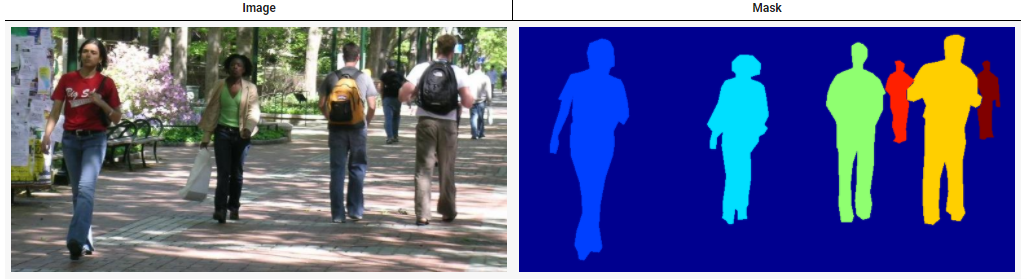

Similar to Part 3 of Project 1, you don't need to create the dataset class to read the images and their masks. However, you will need to create a dataset class for each task (e.g., get bounding boxes from the mask for object detection). It should be able to do transformations relevant to the task (data augmentation). Run the following cell first to download the dataset. Then, run it again multiple times to see different examples.

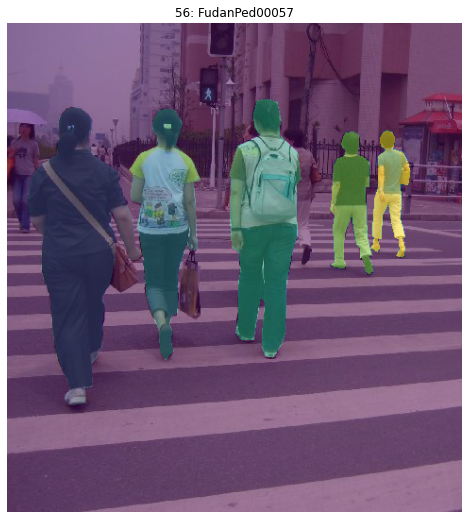

In [9]:
def square_image(image, size=None, color=(0, 0, 0)):
    """Pad and resize a PIL.Image to make it square (width == height)."""
    shape = (max(image.size) if size is None else size,) * 2
    color = ImageColor.getcolor(f'rgb{tuple(color)}', image.mode)
    return ImageOps.pad(image, shape, Image.NEAREST, color)


class PennFudan(Dataset):
    url = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
    md5 = '5aaa3dee905cef73325923716e38fc6d'
    mean = (0.4398, 0.4445, 0.4062)
    std = (0.2635, 0.2507, 0.2577)

    def __init__(self):
        hub_dir = Path(torch.hub.get_dir())
        self.root = hub_dir / f'datasets/{type(self).__name__}/PennFudanPed'
        if not self.root.exists():
            download_and_extract_archive(
                url=self.url,
                download_root=self.root.parent,
                md5=self.md5,
            )
        file_paths = self.root.glob('PNGImages/*.png')
        self.file_names = sorted(p.stem for p in file_paths)

    def __getitem__(self, index):
        name = index if isinstance(index, str) else self.file_names[index]
        image_file = self.root / 'PNGImages' / (name + '.png')
        mask_file = self.root / 'PedMasks' / (image_file.stem + '_mask.png')
        image, mask = Image.open(image_file), Image.open(mask_file)
        assert image.size == mask.size, f'{image.size} != {mask.size}'
        return {'name': name, 'image': image, 'mask': mask}

    def __len__(self):
        return len(self.file_names)

    def __repr__(self):
        return f'{type(self).__name__}(num_images={len(self)})'

    def normalize(self, tensor):
        """Compute `(unnormalized_image_tensor - self.mean) / self.std`."""
        return TF.normalize(tensor, self.mean, self.std)

    def denormalize(self, tensor):
        """Compute `normalized_image_tensor * self.std + self.mean`."""
        std = [1 / s for s in self.std]
        mean = [-m / s for m, s in zip(self.mean, self.std)]
        return TF.normalize(tensor, mean, std)

    def imshow(self, index=None, show=True, ax=None):
        if ax is None:
            figure, ax = plt.subplots(figsize=(12, 9))
        if index is None:
            index = torch.randint(0, len(self), ())
        data_item = self[index]
        ax.imshow(data_item['image'])
        ax.imshow(data_item['mask'], alpha=0.5)
        ax.set_title(str(int(index)) + ': ' + data_item['name'])
        ax.axis('off')
        if show:
            plt.show(figure)
        return ax


_ = PennFudan().imshow()

## MNIST Clutter Dataset

Let's create our own dataset. We will take MNIST digit images and scatter them in a bigger canvas. We will give every digit a random color and randomly rotate, translate, scale, and apply some shear to it. This idea was inspired from [here](https://colab.research.google.com/drive/11M1SJ2DnOmtGF91d58zJKf8BYplcZ27-#scrollTo=8NLVZUO6UKtU). We will add an `instance` flag to choose between whether we want the dataset to be for instance segmentation or semantic segmentation. For semantic segmentation, the mask will have the integers $[-1, 9]$ where the value $-1$ is reserved for the background pixels and $[0, 9]$ are for the actual digit labels. Even if a digit appears multiple times in the image, we will not differentiate their labels in the mask. Whereas, for instance segmentation, we need an additional mask to know each instance's index. However, we don't need to create two masks. We can give every instance a unique value. This value has to be special such that we can to tell what class label it belongs to. For example, we reserve the $1$'s for class $0$, the $100$'s for class $1$, the $200$'s for class $2$, ..., and so on. Now, if the value was $732$, we can immediately tell that this is the instance with index $32$ in class $7$ in this image. Meaning that the mask will have the integers $[-1, 999]$. This way we established a unique mapping similar to the trick we leveraged in `ConfusionMatrix.update()`. We picked the factor $100$ assuming, in the most extreme case, we don't have more than $100$ instances of the same class in a single image. In the following implementation, we will set a maximum number of digits in an image and will use it instead.


/usr/lib/python3/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
<ipython-input-10-77d3827c5536>:77: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered in

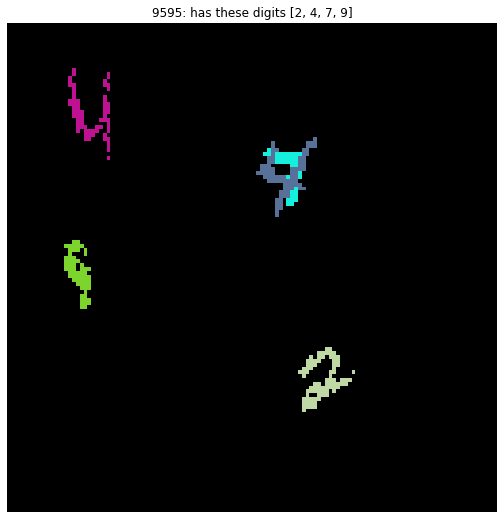

In [10]:
"""
torch.hub is a utility module in Pytorch to simply the process of loading
pretrained models and datasets from various sources. Unified interfaces for loading 
models and datasets.
torch.hub.get_dir() - returns the directory where the datasets and models
are stored after downloading from pytorch hub.
"""
class MNISTClutter(Dataset):
    def __init__(self, instance=True, image_size=128, max_num_digits=10):
        self.instance = True
        self.image_size = image_size
        self.max_num_digits = max_num_digits
        self.mnist = datasets.MNIST(
            root=Path(torch.hub.get_dir()) / f'datasets/MNIST',
            train=False,
            download=True,
            transform=T.ToTensor(),
        )

    def __getitem__(self, index):
        # create the final image and mask placeholders
        image = torch.zeros(3, self.image_size, self.image_size)
        mask = torch.full(image.shape[1:], -1, dtype=torch.long)

        count = [0] * 10  # count[i] is the number of instances with label i
        # we will use a random number generator with the index as the seed
        # this way we make sure that the images are always the same
        rng = torch.Generator('cpu').manual_seed(int(index)) # Create a pytorch number generator
        num_digits = torch.randint(self.max_num_digits, (), generator=rng) + 1 # generate number of digits in the image
        for _ in range(num_digits):
            i = torch.randint(len(self.mnist), (), generator=rng) # choose a random digit
            digit, label = self.mnist[i] # extract digit and label

            # pick a random affine transformation
            pad = (self.image_size - 28) // 2
            angle = torch.randint(-30, 30, (), generator=rng).item() # choose a random rotation angle
            translate = torch.randint(-pad, pad, (2,), generator=rng).tolist() # choose a random translation
            scale = 0.75 + 0.5 * torch.rand((), generator=rng).item() # choose a random scaling factor
            shear = torch.randint(-20, 20, (), generator=rng).item() # choose a random shear

            # pad the digit and apply the transformation
            digit = TF.pad(digit, pad) # pad the digits with pad zeros
            digit = TF.affine(digit, angle, translate, scale, shear) # apply affine transformations

            # accumulate the digit and its mask onto the final image and mask
            # .squeeze remove dimension of one element and create a boolean mask
            valid = digit.squeeze() > 0.5  # ignore small intensities
            # [:, valid] select pixels in all channels espacified by the mask
            # generate a random color for the 3 channels
            image[:, valid] = torch.rand(3, 1, generator=rng)  # random color
            # for the mask, we will use a unique mapping
            # this is similar to the trick we used in ConfusionMatrix.update()
            # generate the mask, create a unique label for the pixels
            # in base of the class label and the count over other digits of the same class
            mask[valid] = self.max_num_digits * label + count[label]
            count[label] += 1

        if not self.instance:  # semantic segmentation
            # we need to get the labels without changing "-1" pixels
            mask[mask >= 0] //= self.max_num_digits
        return image, mask

    def __len__(self):
        return len(self.mnist) * 1  # could be much bigger

    def __repr__(self):
        return f'{type(self).__name__}(num_images={len(self)})'

    def imshow(self, index=None, show=True, ax=None):
        if ax is None:
            figure, ax = plt.subplots(figsize=(12, 9))
        if index is None:
            index = torch.randint(len(self), ()).item()
        image, mask = self[index]
        ax.imshow(TF.to_pil_image(image))
        if self.instance:
            mask[mask >= 0] //= self.max_num_digits
        digits = mask.unique()[1:].tolist()
        ax.set_title(f'{index}: has these digits {digits}')
        ax.axis('off')
        if show:
            plt.show(figure)
        return ax


_ = MNISTClutter(instance=True).imshow()

# Part 1: Semantic Segmentation (6 points)

In this part, the goal is to give every pixel in the input image a class label. This is still a classification task but on pixel level (i.e., samples are pixels instead of images). However, we don't really care how many objects/instances is there in the image (e.g., a pixel in a pedestrian will have the same label as any pixel in any other pedestrian). This means for Penn-Fudan dataset, we have only two classes; pedestrian and background.

## Task 1: Data Preprocessing (1 points)

Before we start with the model, we have to preprocess our training data and apply some data augmentation:

- In `PennFudan()`, the image and the mask are in Pillow format; the format for the Python Imaging Library (PIL)
- We only have $170$ images in the dataset; we need data augmentation to increase the diversity of training samples
- The masks are made for instance segmentation we need to adapt them for semantic segmentation
- The pixel values for the images should be normalized by their mean and std
- It is a good idea to make the image and the mask have equal sides (`width == height`)

If you are curios, you might want to check what [other people](https://arxiv.org/abs/1809.10486) have tried in this task; you can skim through [this](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Segmentation/nnUNet) page.

*Note*: in the code below, we have implemented for you `__getattr__()` as a handy trick to access the attributes of the wrapped dataset even if it was a [subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) created through [`random_split()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split). This is why, you can access stuff like `self.normalize()` and `self.denormalize()` from `PennFudan()` as if they were direct attribute of our segmentation dataset class.

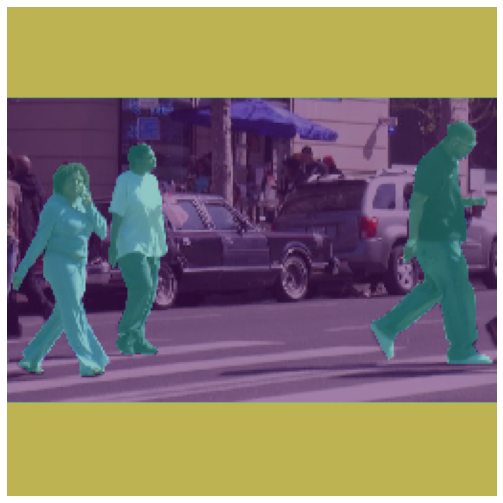

In [11]:
class PFSegmentation(Dataset):
    def __init__(self, dataset=None):
        if dataset is None:
            dataset = PennFudan()
        self.dataset = dataset
        self.training = False
        self.image_size = 256
        self.gaussian_blur = T.GaussianBlur(5)
        self.color_jitter = T.ColorJitter(0.1, 0.1, 0.1, 0.1)

    def __getitem__(self, index):
        # get the image and the mask
        data_item = self.dataset[index]
        image, mask = data_item.pop('image'), data_item.pop('mask')

        # do data augmentation if training
        if self.training:
            # TODO: (0.5 points)
            # complete the following data transforms and understand why such augmentations are needed.
            # sometimes apply color jitter to the image
            if torch.rand(()) < 0.5:
                image = self.color_jitter(image)
            # sometimes horizontally flip the image with the mask
            if torch.rand(()) < 0.5:
                image = T.functional.hflip(image)
                mask = T.functional.hflip(mask)
            # sometimes apply a gaussian blur filter to the image
            if torch.rand(()) < 0.5:
                image = self.gaussian_blur(image)
            
            # Use one of this methods for dataaugmentation
            # checkout T.RandomChoice() and T.RandomOrder()
            transform = T.Compose([
                T.RandomOrder([
                    self.color_jitter,
                    self.gaussian_blur,
                ])
            ])
            # Implement the random choice transform randomly
#             if torch.rand(()) < 0.5:
#                 image = transform(image) 

            # ^^^^^^^^^^^^^^^^^
        
        
        # pad with the image and the mask to squares and resize them
        # the padded area will have a gray color in the image (128, 128, 128)
        # the padded area will have a white color in the mask (255, 255, 255)
        image = square_image(image, self.image_size, color=[128] * 3)
        mask = square_image(mask, self.image_size, color=[255] * 3)
        
        # convert the image and the mask into tensors
        image = self.normalize(TF.to_tensor(image)) # dtype: torch.float32
        mask = torch.from_numpy(np.array(mask))

        # TODO: (0.25 points)
        # change the values in the padded area of the mask from 255 to -1
        # make all pedestrian pixels to have the value 1 and the background 0
        # don't forget to change the dtype of the mask to long (int64)
        mask = mask.long() # convert dtype to long
        mask = torch.where(mask == 255, -1, mask) # Change the padded area pixel values to -1
        mask = torch.where(mask > 0, 1, mask) # make all the pedestrian values to 1, keep 0 to background
        
        # DEBUG
        #unique_vals = torch.unique(mask)
        #for val in unique_vals:
            #print(f"Pixel value {val}")
            
        # ^^^^^^^^^^^^^^^^^
        return image, mask

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return f'{type(self).__name__}(num_images={len(self)})'

    def imshow(self, index=None, show=True, ax=None):
        if ax is None:
            figure, ax = plt.subplots(figsize=(12, 9))
        if index is None:
            index = torch.randint(0, len(self), ())
        image, mask = self[index]
        # TODO: (0.25 points)
        # visualize the mask overlaid on top of the image
        # change all -1 values in the mask to 2 and understand why we do this
        # use TF.to_pil_image() to convert the image and the mask
        # it accepts torch.float and torch.uint8 dtypes but not torch.long
        
        # convert mask -1 values to 2, to visualize we can't have negative values
        mask = (torch.where(mask == -1, 2, mask)).to(torch.uint8) # 0:background, 1:pedestrian, 2:padding
        
        ax.imshow(TF.to_pil_image(self.dataset.denormalize(image)))
        ax.imshow(TF.to_pil_image(mask), alpha=0.5)
        
        # ^^^^^^^^^^^^^^^^^
        ax.axis('off')
        if show:
            plt.show(figure)
        return ax

    def __getattr__(self, name):
        """Search recursively for attributes under self.dataset."""
        dataset = self
        while hasattr(dataset, 'dataset'):
            dataset = dataset.dataset
            if hasattr(dataset, name):
                return getattr(dataset, name)
        raise AttributeError(name)


dataset = PFSegmentation()
dataset.training = True
# _ = dataset[0]
_ = dataset.imshow()

The result above should look like this:

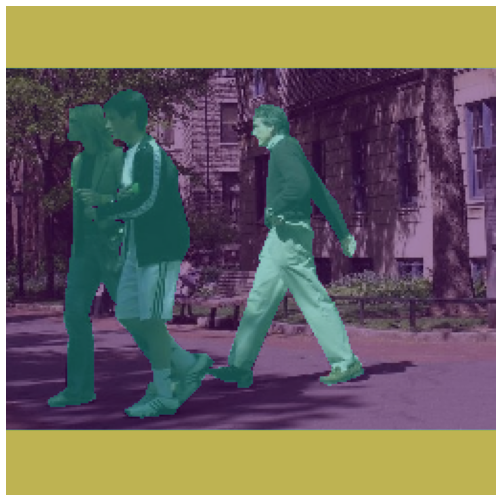


## Task 2: Model Construction (3 points)

We will use fully convolutional networks ([FCNs](https://arxiv.org/abs/1605.06211)). They are capable of accepting input images of any size and outputing segmentation masks with the same size as the input. In general, they tend to be U-shaped (e.g., [U-Net](https://arxiv.org/abs/1505.04597) and [SegNet](https://mi.eng.cam.ac.uk/projects/segnet/)) because they have two parts; encoder and decoder. When designing these types of networks, we need to be aware of the [receptive field](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807). Although, these networks can process arbitrary large images, the aggregated features have a maximum window size. All of this depends on the factor of downsampling/upsampling (a.k.a striding factor). The spatial downsampling can be done using pooling layers (e.g., max-pooling and average-pooling) or convolutions with strides. The upsampling can be done similarily by unpooling layers or transpose convolutions (deconv). The latter generally works better.

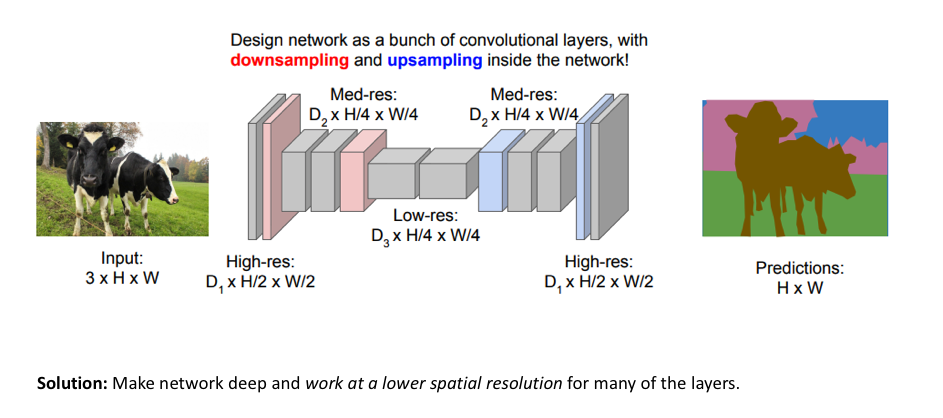

Another problem is that since we have these two big parts (encoder and decoder) that are doing the downsampling and upsampling of the spatial dimensions (height and width), the network can become very deep. This is the main cause behind the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). To remedy this, we add [skip connections](https://theaisummer.com/skip-connections) to the network or use [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activations. Without skip connections. You can still train it end-to-end but you will find it converging slower than expected. The connections can be blockwise or between the encoder and decoder. The type of operation for the connections can vary. For example, they can be additive (residual), multiplicative, or a simple concatenation (dense).

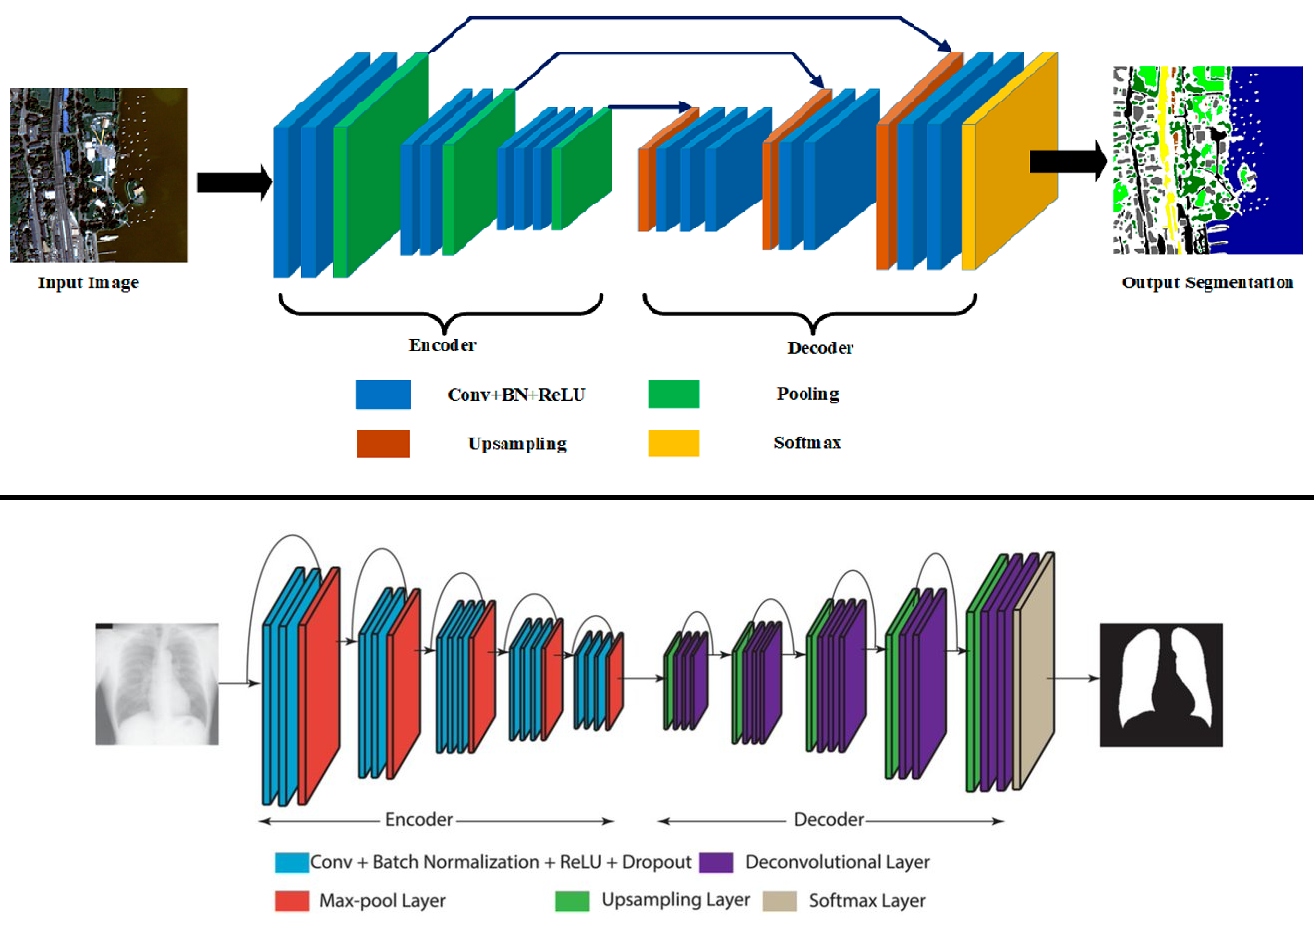

In [12]:
class SimpleSemanticSegmentor(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 32, 5, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 5, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 5, padding=2),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 5, stride=2, padding=0, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, 5, stride=2, padding=0, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, 5, padding=2),
        )

    def forward(self, x):
        latent_vector = self.encoder(x)  # bottleneck
        return self.decoder(latent_vector)


# TODO: (1.5 points)
# study SimpleSemanticSegmentor() above and build a more advanced model
# split the encoder and decoder into blocks
# you can add a batchnorm layer to every block
# use leaky relu with 0.01 negative slope
# add residual connections between the encoder and decoder
# explain the arguments of nn.ConvTranspose2d()
"""
nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
- in_channels: num of channels in the input tensor
- out_channels: output channels
- kernel_size: Size of the kernel(filter)
- stride: stride of the convolution
- padding: padding added to both sides of the input
- output_padding: additional size added to one side of each dimension
- groups: number of groupd that the input and output channels are devided
- dilation: control spacing between kernel elements
- bias: add bias term
- padding_mode: zeros, reflect, or replicate
"""
class ConvBlock(nn.Module):
    def __init__(self, num_input, num_output):
        super().__init__()
        # Define the convolutional block
        self.conv_block = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(num_input, num_output, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_output),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            
            # Second convolutional layer
            nn.Conv2d(num_output, num_output, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_output),
            nn.LeakyReLU(negative_slope=0.01, inplace=True), # 
        )

    def forward(self, x):
        return self.conv_block(x)

class EncoderBlock(nn.Module):
    # Encoder block - Double filter size, and return half size of filters
    # aftet the encoder block
    def __init__(self, num_input, num_output):
        super().__init__()
        # Define the block in the encoder
        # Correspong to 2 convolutions with 
        # LeakyRelu as activation function
        # And batch normalization
        self.block = ConvBlock(num_input, num_output)
        self.max_pool = nn.MaxPool2d((2,2)) # pooling operation for downsampling kernel=2x2
#         self.enc_block = nn.Sequential(
#             ConvBlock(num_input, num_output),
#             nn.MaxPool2d((2,2)) # pooling operation for downsampling kernel=2x2
#         )
    
    def forward(self, x):
        # Pass the input
#         latent_vector = self.enc_block(x)
        # Pass the input through the conv block
        x = self.block(x)
        # Perform max pooling operation
        latent_vector = self.max_pool(x)
        # return the vector from the block and the input for
        # later use in a residual connection
        return latent_vector, x

class DecoderBlock(nn.Module):
    # Decoder Block - Perform a 2D transposed convolution operation
    # and a conv block with the residual connection
    def __init__(self,num_input, num_output):
        super().__init__()
        
        # define the transposed convolution
        # kernel=2 output feature map size twice as input, stride=2 output feature map shifted by 2
        self.conv_trasp_2d = nn.ConvTranspose2d(num_input, num_output, 2, stride=2, padding=0)
        self.conv_block = ConvBlock(num_output+num_output, num_output) # 2*num_output for passing the residual
    def forward(self, x, res):
        
        # First perform the upsampling
        latent_vector = self.conv_trasp_2d(x)
        # Create the residual connection concatenating x an
        latent_vector = torch.cat([latent_vector, res], axis=1)
        # pass to the conv block
#         print(f'deco latent {latent_vector.shape}')
#         print(f'deco res {res.shape}')
        latent_vector = self.conv_block(latent_vector)
        return latent_vector

class SemanticSegmentor(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        
        # Define the encoder 
        self.enc_1 =  EncoderBlock(num_channels,64) # input 3 channels, 64 output
        self.enc_2 =  EncoderBlock(64,128)
        self.enc_3 =  EncoderBlock(128,256)
        self.enc_4 =  EncoderBlock(256,512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Define decoder
        self.dec_1 = DecoderBlock(1024,512)
        self.dec_2 = DecoderBlock(512,256)
        self.dec_3 = DecoderBlock(256,128)
        self.dec_4 = DecoderBlock(128,64)
        
        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1, padding=0) # one output channel

    def forward(self, x):
        
        # Forward pass encoder
        x, r1 = self.enc_1(x)
        x, r2 = self.enc_2(x)
        x, r3 = self.enc_3(x)
        x, r4 = self.enc_4(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
#         print(f'Bottleneck {x.shape}')
#         print(f'residual r4 {r4.shape}')
        
        # Forward pass decoder
        x = self.dec_1(x,r4)
#         print(f'1 deco {x.shape}')
        x = self.dec_2(x,r3)
#         print(f'2 deco {x.shape}')
        x = self.dec_3(x,r2)
#         print(f'3 deco {x.shape}')
        x = self.dec_4(x,r1)
#         print(f'4 deco {x.shape}')
        # Final layer
        output = self.final_layer(x)
        
        return output
# ^^^^^^^^^^^^^^^^^

Let's now define our loss function and write our training code. Although, in Penn-Fudan dataset, we only have two classes (pedestrian "$1$" and background "$0$"), we will write the loss function to work with any number of classes. Think of it as if you are planning to train on MNIST Clutter dataset. Remember that we reserved the value "$-1$" to indicate the padded region in the mask when we resized the images to make them square. This should be incorporated into the loss and the metrics (i.e., we should ignore any pixel with "$-1$" value in the loss and metrics).

In [13]:
# Define an Enum class to represent the different
# phases of training
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VAlID = VAL = enum.auto()
    TESTING = TEST = enum.auto()

"""
Define a function that executes one epoch of training, validation, testing

Paraeters:
- phase: indicates the phase of execution
- model: nn.Module, the model to train/val/test
- loader: DataLoader - the data loader for loading batches of data
- device: torch.device - the device to use in the epoch
- optimizer: the optimizer for training 

Returns:
- metrics: ClassificationMetrics - Object containing the performance metrics of the model
"""
def one_epoch(phase, model, loader, device, optimizer=None):
    
    # Initialize object to track performance
    metrics = ClassificationMetrics(num_classes=2)
    metrics.num_images = metrics.loss = 0  # adds extra values
    
    # Check if we are doing training 
    training = phase is Phase.TRAINING
    # Enable/Disable gradient computation
    with torch.set_grad_enabled(training):
        model.train(training) # set the model mode (train/eval)
        
        # loop over batchs in dataloader
        for batch in loader:
            # move data to device
            images, masks = map(lambda x: x.to(device), batch)

            # forward pass and loss computation
            # TODO: (0.75 points)
            # expect any question on this and change the loss to focus
            # twice as much on pedestrian as background in every batch
            # compare the results to focusing equally on both pedestrian and background
#             weight_classes = (torch.tensor([1,1],dtype=torch.float32)).to(device)
            weight_classes = (torch.tensor([1,2],dtype=torch.float32)).to(device) # Speed up sending to GPU
#             print(images.shape)
            logits = model(images).permute(0, 2, 3, 1).flatten(0, -2) # permute to allow flatten the tensor
            # flatten to get: (batch_size * height * width, num_classes)
            loss = F.cross_entropy(logits, masks.flatten(), weight=weight_classes, ignore_index=-1) # compute cross-entropy between logits and masks
            # ignore_index=-1 - Ignore pixels with value -1
            # loss *= images.shape[1:].numel()  # multiply by image size to scale the loss
            # ^^^^^^^^^^^^^^^^^

            # backward pass
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update batch metrics
            metrics.num_images += len(images)
            metrics.loss += loss.item() * len(images)
            metrics.update(logits.data.argmax(dim=1), masks.flatten())

    metrics.loss /= metrics.num_images
    return metrics
"""
(1) What metric should we choose?
    f1_score, iou, precision, recall, accuracy
    f1_score: combine recall and precision, useful when class imbalance
    IoU: Measures overlap between predicted and ground truth
    accuract: calculate the percentage of correctly classified pixels
                not good option when exist class imbalance.
(2) Should it be a training or a validation metric?
    it should be validation metric because the purpose of validation
    step is to provide an evaluation of the model performance 
    for unseen data, how well the model generalize 
(3) Should it be weighted over the classes or the class mean?
    It depends on the dataset, if it is imbalanced then it may be
    beneficial to use weighted metrics to account for the imbalance

"""
def train(model, train_loader, val_loader, optimizer, device, epochs):
    best_value = 0
    best_state = None
    last_best = 0
    logs =[]
    for epoch in range(epochs):
        print(f'Epoch: {epoch}'.ljust(11) + '#' * 42)
        train_metrics = one_epoch(
            Phase.TRAINING,
            model,
            train_loader,
            device,
            optimizer,
        )
        print(f'TRAINING: Loss = {train_metrics.loss}')
        print(train_metrics, end='\n\n')
        
        val_metrics = one_epoch(Phase.VALIDATION, model, val_loader, device)
        print(f'VALIDATION: Loss = {val_metrics.loss}')
        print(val_metrics, end='\n\n')
        
        # add the metrics to the logs
        logs.append((train_metrics, val_metrics))
        
        # TODO: (0.75 points)
        # we will keep track of the best model according to a metric
        # for the Penn-Fudan dataset:
        # You should understand:
        # (1) What metric should we choose?
        # (2) Should it be a training or a validation metric?
        # (3) Should it be weighted over the classes or the class mean?
        # You are also required to:
        # change the following to what you feel is the best
                # Hint: you can leave it as is for now and train for 5 epochs
        #       visualize and study the behavior of the metrics then decide
        #       there is no single right answer, we want to see your reasoning
        #       this doesn't change the training the loss and the data do
        #       if we want to optimize for this, we need to change them
        # https://paperswithcode.com/task/semantic-segmentation
        
        # possible metrics = ('accuracy', 'recall', 'precision', 'f1_score', 'iou')
#         current_value = train_metrics.iou # look for training metrics
#         current_value = val_metrics.weighted(val_metrics.iou) # get the weighted iou
        current_value = val_metrics.iou.mean() # Get the mean of the iou score
#         current_value = val_metrics.iou # look for validation metrics
        print(current_value)
        if current_value >= best_value:
            last_best = 0
            best_value = current_value
            best_state = {
                'epoch': epoch,
                'model': model.state_dict(), # save a copy of the parameters
                'optimizer': optimizer.state_dict(), # TODO: Understand why we should save the optimizer parameters.
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
            }
            # here we can save the checkpoint to file we want
        else:
            last_best+=1
        # ^^^^^^^^^^^^^^^^^
        
        # here we can do learning rate scheduling if we want
#         scheduler.step()
        
        # early stopping if loss is NaN (not a number) or infinity
        if math.isnan(train_metrics.loss) or math.isinf(train_metrics.loss):
            print('Reached invalid loss! (no point in continuing)')
            break
        
        # TODO
        # do early stopping if the model did not improve in the last 5 epochs
        # this number is called patience and it is a hyper-parameter we tune
        # you should print a meaningful message like above
        # you should understand why early stopping is needed
        patience = 5
        if last_best == patience:
            print(f'No improving for {patience} epochs, stopping training...')
            break
        
        # ^^^^^^^^^^^^^^^^^
        print('#' * 53 + '\n')
    return best_state, logs
        

## Task 3: Training and Visualization (2 points)

In [14]:
"""
Batch_size:
Larger batch size help to converge faster but in terms of performance having an smal batch size
help to generalize the data and learn patterns avoiding learning the data. 
"""
torch.manual_seed(0)
# torch.set_deterministic(True)
# split the dataset in training(136), val(17), and test(17)
data_splits = random_split(PennFudan(), [136, 17, 17])
# apply PFSegmentation to the elements of data_splits
# PFSegmentation(pytorch Dataset) load the data and apply data transformations
train_set, val_set, test_set = map(PFSegmentation, data_splits)
train_set.training = True # set training true in training dataset

# TODO: (1.25 points)
# change the following + the model + loss to get the results you desire
# there is no required performance threshold you need to reach
# however, you have to satisfy the following:
#   - train for at least 30 epochs or training stops early
#   - the loss must be decreasing
#   - the metric you chose before must be moving
#   - its value must be better than random
#   - you must avoid underfitting or overfitting
device = torch.device('cuda:0')
train_loader = DataLoader(
    train_set,
    batch_size=4,  # is bigger batch_size always better? 4
    shuffle=True,
    num_workers=4,
    pin_memory=device.type == 'cuda',
    drop_last=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=17,
    num_workers=1,
    pin_memory=device.type == 'cuda',
)
test_loader = DataLoader(
    test_set,
    batch_size=17,
    num_workers=1,
    pin_memory=device.type == 'cuda',
)

epochs = 30
# model = SimpleSemanticSegmentor(3, 2).to(device)
model = SemanticSegmentor(3, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best, logs = train(model, train_loader, val_loader, optimizer, device, epochs)
# ^^^^^^^^^^^^^^^^^

Epoch: 0   ##########################################
TRAINING: Loss = 0.5544871617765987
   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   75.12%   80.22%   88.88%   84.33%   72.91%
       1   75.12%   49.34%   33.08%   39.61%   24.69%
-----------------------------------------------------
    Mean   75.12%   64.78%   60.98%   61.97%   48.80%
Weighted   75.12%   75.12%   79.65%   76.93%   64.93%

VALIDATION: Loss = 12.32683277130127
   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   39.88%   32.47%   86.62%   47.24%   30.92%
       1   39.88%   75.72%   18.81%   30.13%   17.74%
-----------------------------------------------------
    Mean   39.88%   54.10%   52.72%   38.68%   24.33%
Weighted   39.88%   39.88%   75.01%   44.31%   28.66%

tensor(0.2433, device='cuda:0')
#####################################################

Epoch: 1   #################

VALIDATION: Loss = 0.22499187290668488
   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   92.21%   94.93%   95.64%   95.28%   90.99%
       1   92.21%   79.04%   76.32%   77.65%   63.47%
-----------------------------------------------------
    Mean   92.21%   86.99%   85.98%   86.47%   77.23%
Weighted   92.21%   92.21%   92.33%   92.27%   86.28%

tensor(0.7723, device='cuda:0')
#####################################################

Epoch: 9   ##########################################
TRAINING: Loss = 0.2606126490761252
   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   90.21%   92.46%   95.66%   94.04%   88.74%
       1   90.21%   78.84%   67.45%   72.70%   57.11%
-----------------------------------------------------
    Mean   90.21%   85.65%   81.56%   83.37%   72.93%
Weighted   90.21%   90.21%   91.00%   90.51%   83.51%

VALIDATION: Loss = 0.25282

Run the cell below after training for a nice visualization of these metrics:

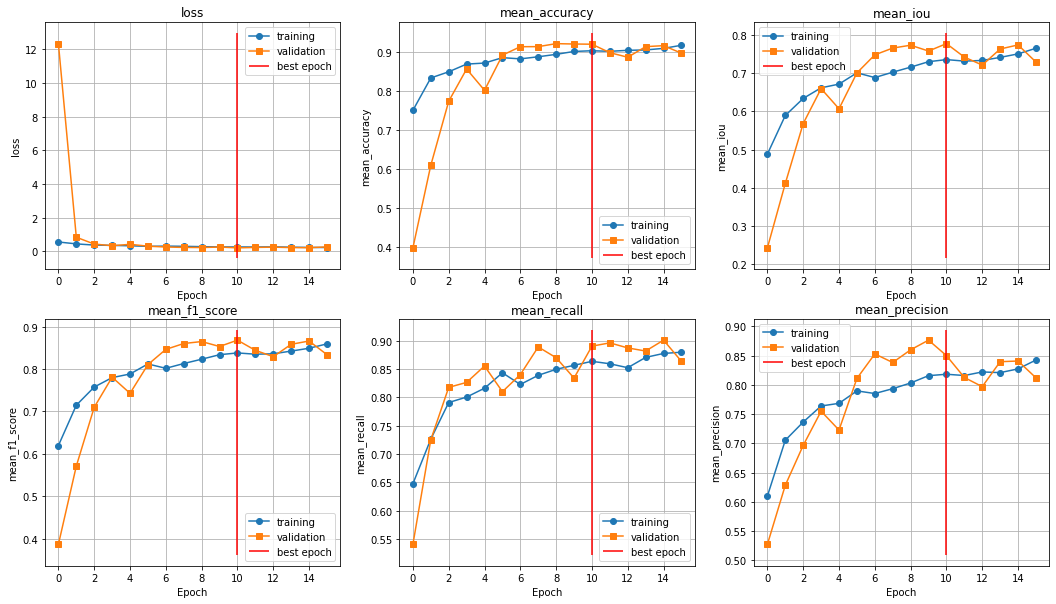

In [15]:
plots = [  # pick the metrics you want to see
    'loss',
    'mean_accuracy',
    'mean_iou',
    'mean_f1_score',
    'mean_recall',
    'mean_precision',
    # ...,
]
train_metrics, val_metrics = zip(*logs)

columns = min(3, len(plots))
rows = math.ceil(len(plots) / columns)
figure, axes = plt.subplots(rows, columns, figsize=(columns * 6, rows * 5))
for name, ax in zip(plots, axes.flat):
    train_plot = [float(getattr(m, name)) for m in train_metrics]
    val_plot = [float(getattr(m, name)) for m in val_metrics]
    ax.plot(train_plot, marker='o', label='training')
    ax.plot(val_plot, marker='s', label='validation')
    ax.vlines(best['epoch'], *ax.get_ylim(), color='r', label='best epoch')
    ax.set_title(name)
    ax.set_ylabel(name)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid()

# figure.tight_layout()
plt.show(figure)

In [16]:
# TODO: (0.5 points)
# currently the model has the state of the last epoch
# it is not necessarily the best state, so load the best checkpoint
# compute and print the testing metrics using the best model
plots = [  # pick the metrics you want to see
    'loss',
    'mean_accuracy',
    'mean_iou',
    'mean_f1_score',
    'mean_recall',
    'mean_precision',
    # ...,
]

# Load the best checkpoint of the model
model_params = best['model'] # get the params from the saved best dictionary
model.load_state_dict(model_params) # load the params in the model
device = torch.device('cuda:0') # Set the device
test_metrics = one_epoch(Phase.TESTING, model, test_loader, device) # Configure phase as testing and pass

# Print the results of the inference
print("Test inference segmentation task")
print(test_metrics)
    
# ^^^^^^^^^^^^^^^^^

Test inference segmentation task
   Class  accuracy  recall precision f1_score     iou
-----------------------------------------------------
       0   87.99%   92.23%   92.67%   92.45%   85.96%
       1   87.99%   71.29%   69.99%   70.63%   54.60%
-----------------------------------------------------
    Mean   87.99%   81.76%   81.33%   81.54%   70.28%
Weighted   87.99%   87.99%   88.07%   88.03%   79.61%


<h2>FCN-8s</h2>

People used various tricks to do semantic segmentation that are relevant and might help you in your own research. Take FCN-8s ([paper](https://arxiv.org/abs/1605.06211) - [code](https://github.com/shelhamer/fcn.berkeleyvision.org)) as an example. The idea there was to take a pre-trained image classification model and use it as the encoder part of the segmentation model. They took a [VGG16](https://neurohive.io/en/popular-networks/vgg16/) classifier trained on [ImageNet](http://www.image-net.org/) dataset and froze its weights to [fine-tune](https://deeplizard.com/learn/video/5T-iXNNiwIs) only the shallow decoder part ([transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning)).

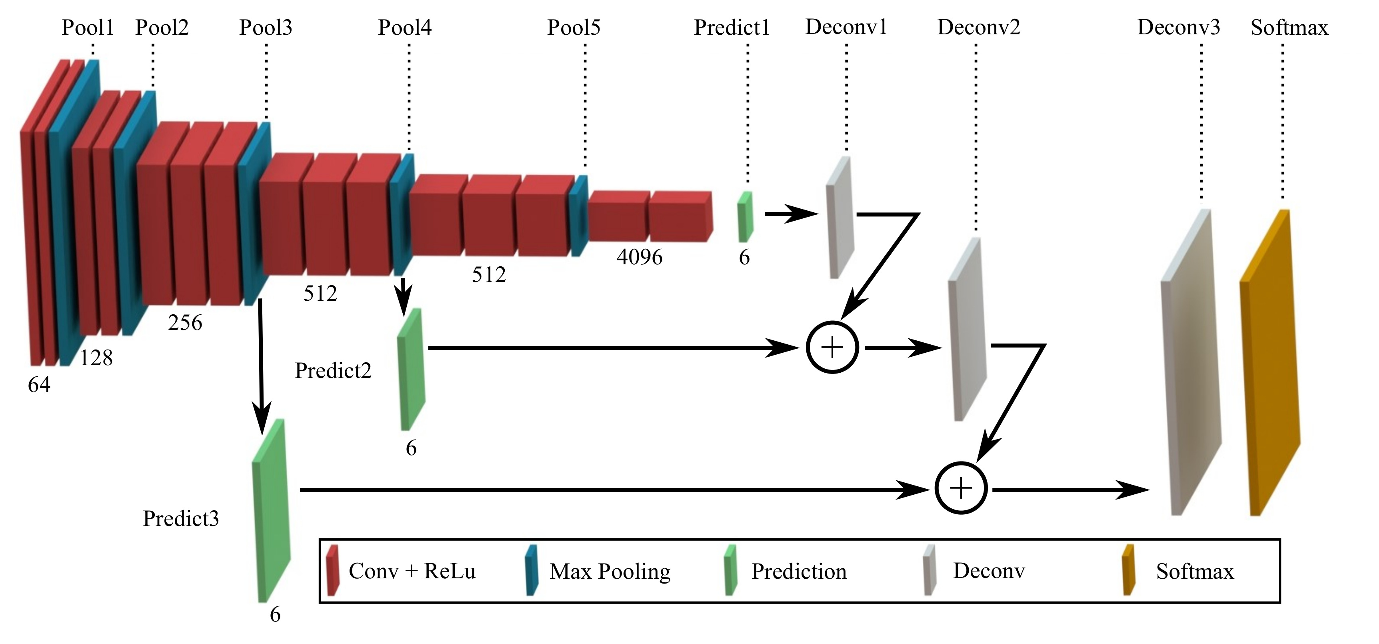

In addition, they converted the fully connected layers of VGG16 into 2D convolutional layers while preserving the weights.

In [17]:
"""
The purpose of the function is to map a linear layer to a convolutional layer. The two operations
are equal in the sense that contains the same number of paramters and perform the same operation
The function create a conv layer with the same ouput size of the linear layer and with a kernel of (in_height, in_width)

"""
# TODO: Understand why the following two operations are equal (mapping linear layers to equivalent convs) (0.25 points)
def linear_to_conv2d(linear, in_height=1, in_width=None):
    """Convert 'nn.Linear' to `nn.Conv2d` and copy the parameters"""
    if in_width is None:
        in_width = in_height
    has_bias = linear.bias is not None # Check if the linear has bias
    
    # create conv2d
    conv2d = nn.Conv2d(
        in_channels=linear.in_features // (in_height * in_width), # num_input_fetures/h*w
        out_channels=linear.out_features, # = output features of the linear layer
        kernel_size=(in_height, in_width), # define kernel size of the filtes
        bias=has_bias, # define if contain bias
    ).to(linear.weight.device, linear.weight.dtype)
    
    # copy the weights and biases
    # reshape the weights of the linear layer to the shape of the conv layer
    # to use the weights of the linear in the conv layer
    conv2d.weight.data.copy_(linear.weight.view(conv2d.weight.shape))
    if has_bias:
        conv2d.bias.data.copy_(linear.bias) # if linear has bias assign bias to conv layer
    return conv2d


# let's say this was an output of a conv2d layer that is flattened
# to be as input to the linear layer that we want to convert to conv2d
batch_size = 10
channels = 2
height = 3  # this can be 1
width = 5  # this can be 1
x = torch.randn(batch_size, channels, height, width).double()

# and this is the linear layer that we want to convert
out_features = 7
lin = nn.Linear(x.shape[1:].numel(), 7).double()

# this is how it is done
conv = linear_to_conv2d(lin, height, width).double()

# let's check that their output is the same
print(torch.allclose(lin(x.flatten(1)), conv(x).flatten(1)))

True


# Part 2: Object Detection (4 points)

In this part, we will add to image classification models the ability to localize objects. So, not only we need to know what objects are in the image, we also want to have the coordinates of the bounding boxes enclosing them. This task combines classification (for the label) and regression (for the bounding box). However, in Penn-Fudan, we only have a single object type; pedestrian. If we have a bounding box, we know that it belongs to a pedestrian. So, no classification is needed for this dataset; only regression. Instead, we can use the MNIST Clutter dataset. Every digit is an object that can be one of $10$ classes. The difficulty in this dataset lies in overlapping digits.

You are highly encouraged to watch [lessons 1 to 10](https://www.youtube.com/watch?v=GSwYGkTfOKk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=23) covering object detection from [deeplearning.ai](https://www.deeplearning.ai/) (Course 4 - Week 3) before proceeding.

<!-- Instead, we will put a bounding box on all annotated pedestrians in the image and set their count as the class label. -->

<h2>Classification + Localization</h2>

The task of classification with localization is the simplest form of object detection were we assume there is always one bounding box in the image. We could train two separate models, one for classification and one for regression, but this seems redundant. Instead, we can train a single backbone model with two heads. This is known as [multi-task learning](https://ruder.io/multi-task/). The loss function will be a weighted sum of the classification loss and the regression loss. The weight we choose is a hyper-parameter that will decide which task we want the model to focus more on. If we want to be extra careful, we should bear in mind the range of values each loss take when choosing the weight (trade-off coefficient).

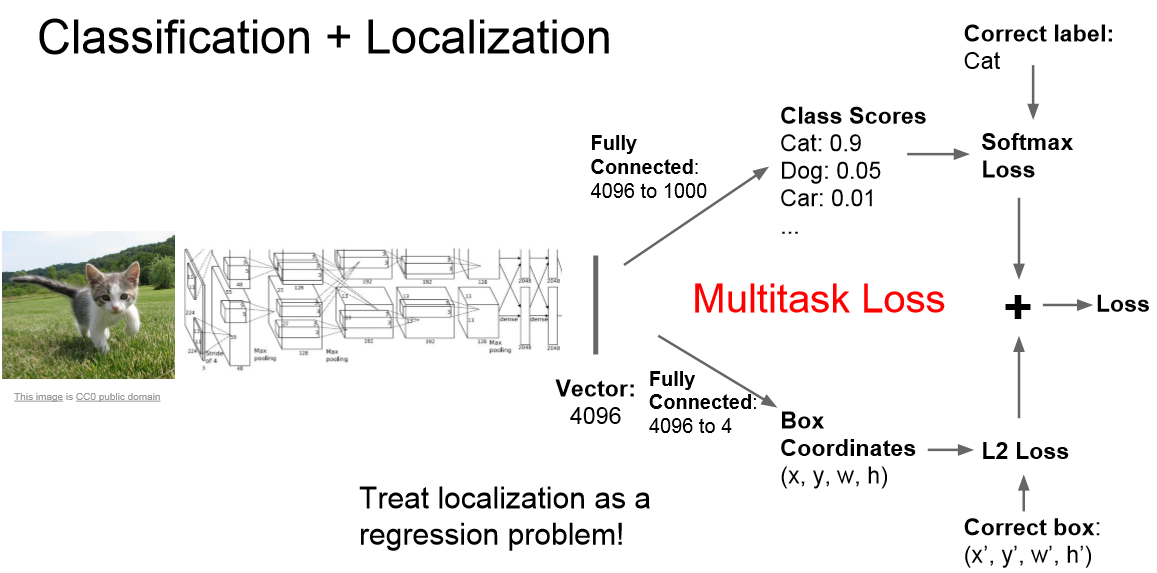

In [18]:
# simple example of classification + localization
class Localizer(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=2),
            nn.ReLU(inplacex=True),
            nn.Conv2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )
        self.regressor = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 4),  # a bounding box needs 4 values
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        bounding_boxes = self.regressor(features)
        return logits, bounding_boxes

    @staticmethod
    def loss(outputs, ground_truth, beta=0.5):
        assert 0 <= beta <= 1
        logits, bounding_boxes = outputs
        gt_label, gt_bounding_boxes = ground_truth
        xe = F.cross_entropy(logits, gt_label)
        bb = F.mse_loss(bounding_boxes, gt_bounding_boxes)
        return (1 - beta) * xe + beta * bb

<h2>Intersection over Union (IoU)</h2>

To evaluate the performance of object detection, we need meaningful metrics. What we get as output, are bounding boxes and class labels. Fortunately, we can reuse the classification metrics by converting the detection result into something that looks like binary classification result. In other words, given a predicted bounding box and a ground truth box, we should be able to say whether the prediction was $\text{TP}$, $\text{FN}$, $\text{FP}$, or $\text{TN}$. We do this by checking if the ratio of the boxes' intersection area to the boxes' union area is greater than a certain threshold ([$\text{IoU} \geq t$](https://www.youtube.com/watch?v=ANIzQ5G-XPE&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=27)).

*Note*: This is exactly what `ClassificationMetrics.iou` computes if we convert the bounding boxes into binary segmentation masks (i.e., what is inside the box is white and everything else is black; do this for the predicted box and the ground truth box and compute the $\text{IoU}$).

For a certain threshold value, we can repeat this and accumulate a confusion matrix for the entire detection task.

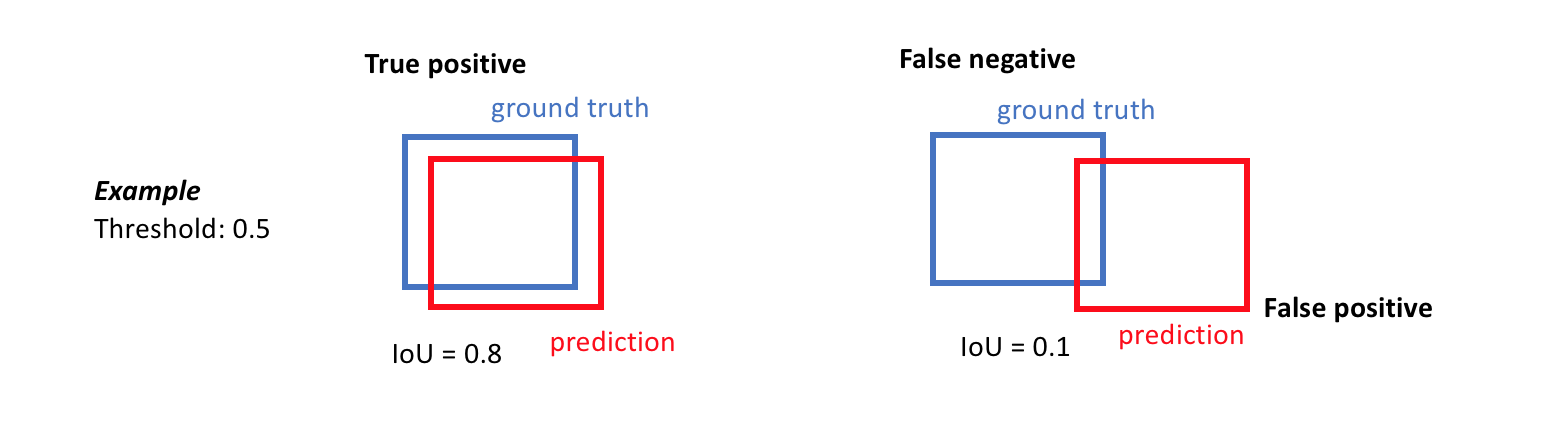

## Task 1: Data Preprocessing (0.75 points)

The canonical way of storing the bounding boxes coordinates is not their absolute pixel location along the $x$-axis (width) and $y$-axis (height). Mainly, because the input images could have different dimensions. As we know, ML methods train much better with normalized values in a fixed range. So, we will assume that the height and the width of the image are in the range $[0, 1]$ extending from the top-left corner to the bottom-right corner. Then, we define a bounding box in a 2D image by four values. One way is using two 2D points; the left-top $(x_\min, y_\min)$ and right-bottom $(x_\max, y_\max)$ corners of the bounding box. However, we will have some implicit constraints that come with this choice that we need to enforce which are $x_\min < x_\max$ and $y_\min < y_\max$. A better choice is picking a single 2D point (e.g., the center of the bounding box $(c_x, c_y)$) and the bounding box dimensions (i.e., width and height $(w, h)$). Hence, $(c_x, c_y, w, h)$ is an example of a bounding box.

*Note*: we are familiar with having the $x$-axis (width) come always before the $y$-axis (height). However, in PyTorch, it is the opposite (rows before columns). The convention when working with tensors is to start the dimensions from right-to-left (e.g., Batch Size x Channels x Height x Width).

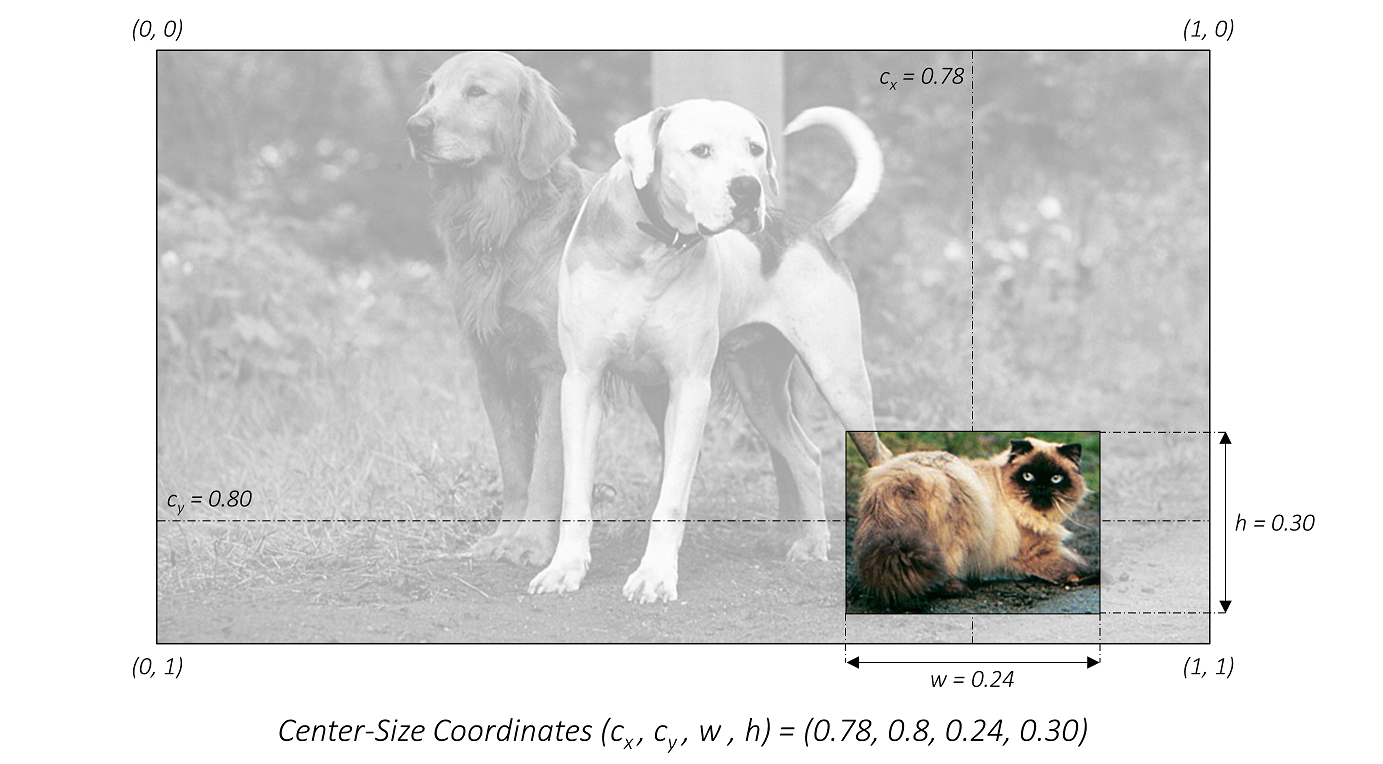

/usr/lib/python3/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)
<ipython-input-19-54a53f07d6bf>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_colors) # get color map and number of colors


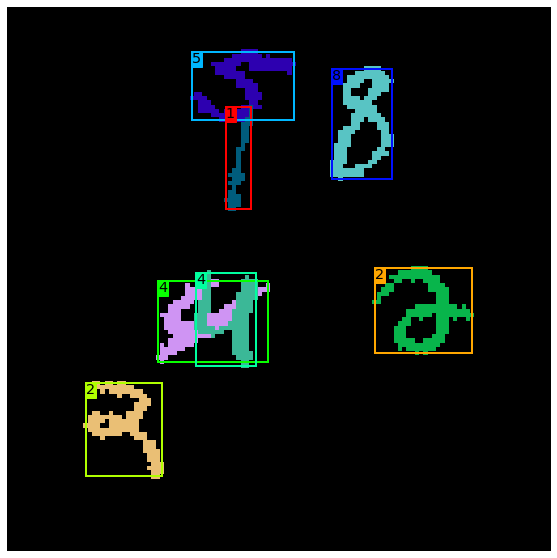

In [19]:
def plot_image_with_boxes(image, bboxes, labels, show=True, ax=None):
    height, width = image.shape[-2:] # extract dimensions
    if ax is None: # if no axes object, create figure with the aspect ration of the image
        figure, ax = plt.subplots(figsize=(int(width / height * 10), 10))

    ax.imshow(TF.to_pil_image(image)) # convert to PIL image and show 

    count = 0
    num_colors = 10
    colors = plt.cm.get_cmap('hsv', num_colors) # get color map and number of colors
    for bbox, label in zip(bboxes, labels): # iterate over bboxes and labels
        color = colors(count % num_colors) # get a color value
        count += 1

        b_x, b_y, b_w, b_h = bbox.cpu() # extract bboxes from tensor
        top = (b_y - b_h / 2) * height
        left = (b_x - b_w / 2) * width
        ax.add_patch(patches.Rectangle( # add rectanle patch to the axes obj with the parameters
            (left, top), b_w * width, b_h * height,
            linewidth=2, fill=False, color=color,
        ))
        # add a text label to the axes 
        ax.text(
            left, top, label, color='black',
            verticalalignment='top',
            fontsize='x-large',
            bbox={'color': color, 'pad': 1},
        )

    ax.axis('off') # turn off axis lines
    if show:
        plt.show(figure) # show the plot
    return ax


class MCDetection(Dataset):
    def __init__(self, dataset=None):
        # if the dataset is not provided
        if dataset is None:
            dataset = MNISTClutter(instance=True)
        self.dataset = dataset

    def __getitem__(self, index):
        # get the image and the mask
        image, mask = self.dataset[index]
        # we will not do data augmentation since this is
        # an automatically generated dataset
        # we can increase the number of images as we want

        max_digits = self.max_num_digits
        # convert mask to bounding boxes and labels
        bboxes, labels = self.mask_to_bounding_boxes(mask, max_digits)
#         print(f'bboxes shape: {bboxes}')
#         print(f'labels shape: {labels}')
#         print(f'max_digits: {max_digits}')

        # TODO: (0.25 points)
        # we are going to form batches in the dataloader later
        # but so far, PyTorch doesn't support nested tensors natively
        # https://github.com/pytorch/nestedtensor
        # this is why we need to pad the bboxes and labels to
        # self.max_num_digits with 0's and -1's, respectively
        # Hint: you can do it with F.pad() or torch.cat()
        
        # pad bboxes and labels with 0's and -1s to have the same size self.max_num_digits
        # pad bboxes tensor with zeros along last dimension
        bboxes = F.pad(bboxes, (0,0,0,(self.max_num_digits - len(bboxes))), 'constant', value=0)
        labels = F.pad(labels, (0,(self.max_num_digits - len(labels))), 'constant', value=-1)
        # ^^^^^^^^^^^^^^^^^
#         print(f'bboxes padded shape: {bboxes.shape}')
#         print(f'labels padded shape: {labels.shape}')

        # the (shape, dtype, range) of the outputs is as follows
        # image: [channels x height x width] torch.float32 [0, 1]
        # bboxes: [self.max_num_digits x 4] torch.float32 [0, 1]
        # labels: [self.max_num_digits] torch.long [-1, 9]
        return image, bboxes, labels

    @staticmethod
    def mask_to_bounding_boxes(mask, max_objects_per_class=1):
        assert mask.ndim == 2, 'mask must be 2D'
        assert mask.dtype == torch.long, 'mask.dtype must be long'
        # TODO: (0.5 points)
        # Be ready to answer any question on this
        # also, compute the normalized center-size coordinates
        # the visualized bounding boxes must fit the digits perfectly
        labels = []
        bounding_boxes = []
        valid = mask >= 0
        object_ids = mask[valid].unique() # get unique object id in the mask
#         print(f'obj_ids shape: {object_ids.view(-1, 1, 1).shape}')
        
        # we use broadcasting here as in ClassificationMetrics.update()
        # object_ids.view, reshape tensor without copying memory
        object_masks = object_ids.view(-1, 1, 1) == mask # create a mask for each object_id
#         print(f'obj_masks shape: {object_masks.shape}')
        height, width = mask.shape
        
        for object_id, object_mask in zip(object_ids, object_masks):
            object_label = object_id // max_objects_per_class # get the label integer
#             print(f'obj_label loop: {object_label}')
#             print(f'obj_mask loop shape: {object_mask.shape}')
            y, x = torch.where(object_mask)  # indices of nonzero elements
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()
            
#             print(f'x loop: {x_min} : {x_max}')
#             print(f'y loop: {y_min} : {y_max}')
            
            # normalize the bboxes values with the image shape
            b_x = (x_min + (x_max - x_min) / 2) / width
            b_y = (y_min + (y_max - y_min) / 2) / height
            b_w = (x_max - x_min)/width
            b_h = (y_max - y_min)/height

            bounding_boxes.append([b_x, b_y, b_w, b_h])
            labels.append(object_label)
        labels = torch.as_tensor(labels)
        bounding_boxes = torch.as_tensor(bounding_boxes)
        return bounding_boxes, labels
        # ^^^^^^^^^^^^^^^^^

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return f'{type(self).__name__}(num_images={len(self)})'

    def imshow(self, index=None, show=True, ax=None):
        if index is None:
            index = torch.randint(0, len(self), ())
        image, bboxes, labels = self[index]
        bboxes = bboxes[labels >= 0]
        labels = labels[labels >= 0].tolist()
        return plot_image_with_boxes(image, bboxes, labels, show, ax)

    def __getattr__(self, name):
        """Search recursively for attributes under self.dataset."""
        dataset = self
        while hasattr(dataset, 'dataset'):
            dataset = dataset.dataset
            if hasattr(dataset, name):
                return getattr(dataset, name)
        raise AttributeError(name)


_ = MCDetection().imshow()
# dataset = MCDetection()
# _ = dataset[0]

## Task 2: Model Construction (3.25 points)

Unlike semantic segmentation where there is a general consensus on what works and what doesn't in terms of model architecture and training, object detection is far more complicated. It started out by casting down the detection task into [different scale sliding window + classification](https://www.youtube.com/watch?v=5e5pjeojznk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=25). Then, came [region proposal networks (RPNs)](https://www.youtube.com/watch?v=6ykvU9WuIws&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=31) where the detection was split into two stages; efficiently generating proposals a.k.a. region of interest (RoI) using methods like [selective search](https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/) then applying a classifier on them (e.g. [R-CNN, Fast R-CNN](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e), ...). Training these models end-to-end used to be cumbersome. Meanwhile, parallel efforts were advocating for a single stage detection like [SSD](http://jany.st/post/2017-11-05-single-shot-detector-ssd-from-scratch-in-tensorflow.html) and [YOLO](https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30). These methods are [anchor-based](https://www.youtube.com/watch?v=RTlwl2bv0Tg&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=29), where the set of possible bounding boxes the model can predict are defined apriori and they are called anchors. The model just predict small offsets and scales to these anchors. Furthermore, the community came up with [anchor-free](https://github.com/XinZhangNLPR/awesome-anchor-free-object-detection) detection like [CenterNet](https://arxiv.org/abs/1904.08189) and [OneNet](https://arxiv.org/abs/2012.05780). All these methods have their pros and cons. They are in an [arms race](https://www.programmersought.com/article/36113497597/) for speed (more frames per second) and accuracy (high precision).

Check this [blog](https://lilianweng.github.io/lil-log/2018/12/27/object-detection-part-4.html) or [book chapter](https://livebook.manning.com/book/grokking-deep-learning-for-computer-vision/chapter-7/v-7/201) for a more detailed summary and [this repo](https://github.com/facebookresearch/detectron2) if you are interested in a PyTorch-friendly detection library.

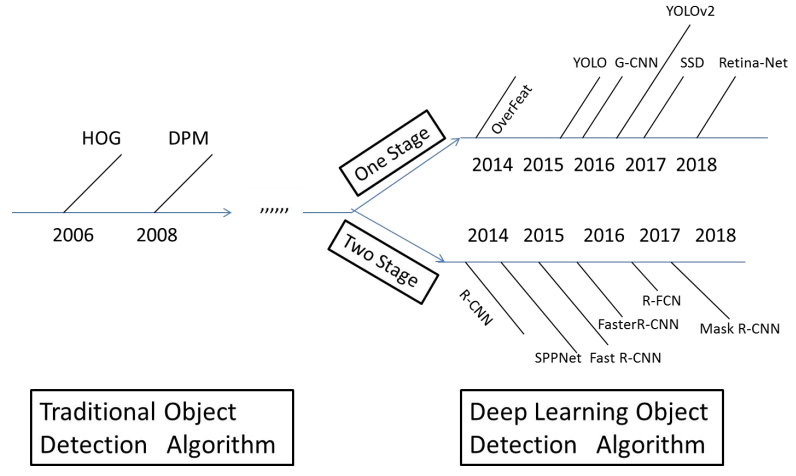

<h2>YOLOv3</h2>

We will work with the [You Only Look Once (YOLO) V3](https://pjreddie.com/darknet/yolo/) object detector as it is one of the most efficient detectors with reasonable precision. It reaches real-time detection (e.g., an inference forward pass with images of size $416 \times 416$ takes just $29$ milliseconds on a Titan X GPU). It is an [anchor-based detection method](https://www.youtube.com/watch?v=RTlwl2bv0Tg&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=29). It divides the image into a regular grid of $S \times S$ cells. Each grid cell will have $K$ anchors. An anchor is just a bounding box ($4$ values) with $C$ class label probabilities (logits) and an additional confidence score $p_c$, sometimes called objectness score. The confidence is $1$ if there is an object in the bounding box and $0$ otherwise. So, each cell can be specified by $K \times (1 + 4 + C)$ values. Each anchor has a predefined "prior" shape (height $p_h$ and width $p_w$). For example, we can have for each grid cell three anchors; one for tall objects, one for wide objects, and one for square objects (we can define more). Let's see an example where $S=3$, $K=2$ (with tall and wide anchors only), and $C=3$. This only shows the anchors of the cell in the center as the center of the person and the car lie both on it:

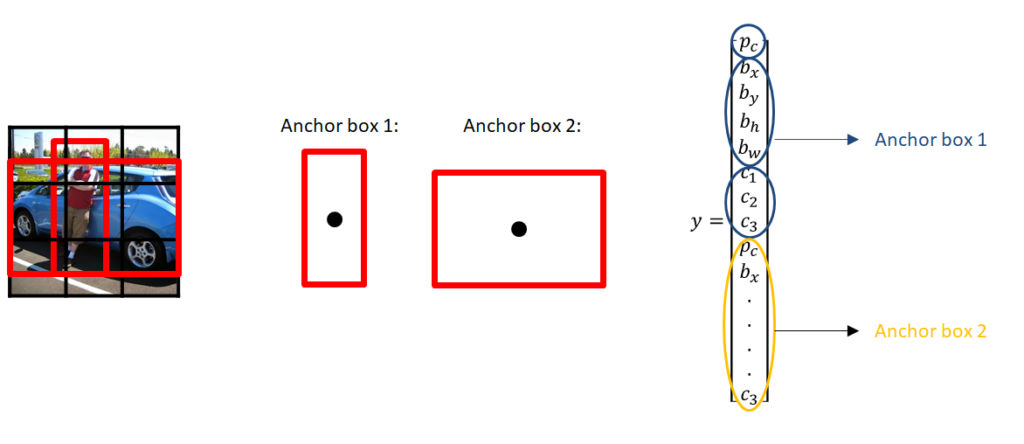

The problem with this method is although there is at most $N = S \times S \times K = 18$ objects that can be detected in this image, no more than $K$ objects can share the same cell. For instance, if there was another person standing to the left of the red-shirt guy, their center would be in the same grid cell but we only have two anchors and they are already taken by the car and the other man. The solution is to have more anchors. However, what if there are small objects that we want to detect? This is why YOLOv3 decided to have three sets of detections; $y_1$: large $S = \frac{1}{32}\text{I}$, $y_2$: medium $S = \frac{1}{16}\text{I}$, and $y_3$: small $S = \frac{1}{8}\text{I}$ where $\text{I}$ is the original image size. Although $S$ for $y_1$ is smaller than $S$ for $y_2$, we call it large because the cell size is larger with respect to the original image. For example in YOLOv3, $I=416$ (i.e., $S_{y_1}=13$, $S_{y_2}=26$, $S_{y_3}=52$) and we have three anchors per grid cell for all scales which have the following prior shapes; $(p_w \times p_h)$ in pixels:

- $y_1$: $(116 \times 90), (156 \times 198), (373 \times 326)$
- $y_2$: $(30 \times 61), (62 \times 45), (59 \times 119)$
- $y_3$: $(10 \times 13), (16 \times 30), (33 \times 23)$

These numbers might look random from a first glance but they are computed from the [COCO](https://cocodataset.org/) detection benchmark dataset. The authors looked at all ground truth boxes and used [k-means clustering](https://github.com/ultralytics/yolov3/blob/166a4d590f08b55cadfebc57a11a52ff2fc2b7d3/utils/autoanchor.py#L58-L155) to find the most common shapes. These anchors work best on this specific dataset.

In [20]:
class SpreadDim(nn.Module):
    """Spread a tensors dimension into multiple dimensions."""
    def __init__(self, *dims, dim):
        super().__init__()
        self.dims = dims
        self.dim = dim

    def forward(self, x):
        shape = list(x.shape) # Get the shape of the input tensor
        # Remove the dimension to spread from the shape and compute the size of the new dimensions
        rest = shape.pop(self.dim) // math.prod(self.dims) 
        # Combine the given dimensions with the new dimensions
        dims = list(self.dims) + ([] if rest == 1 else [rest])
        return x.view(shape[:self.dim] + dims + shape[self.dim:])

class SimpleDetector(nn.Module):
    def __init__(self, num_channels, num_anchors, num_classes):
        super().__init__()
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        out_channels = num_anchors * (1 + 4 + num_classes)
        self.net1 = nn.Sequential(
            nn.Conv2d(num_channels, 32, 3, padding=1),  # S = I
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # S = I / 2
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # S = I / 4
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # S = I / 8
            nn.ReLU(inplace=True),
        )
        self.net2 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # S = I / 16
            nn.ReLU(inplace=True),
        )
        self.net3 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, stride=2, padding=1),  # S = I / 32
            nn.ReLU(inplace=True),
        )
        self.pred1 = nn.Conv2d(256, out_channels, 3, padding=1)
        self.pred2 = nn.Conv2d(512, out_channels, 3, padding=1)
        self.pred3 = nn.Conv2d(1024, out_channels, 3, padding=1)
        self.spread_dim = SpreadDim(1 + 4 + num_classes, dim=1)
        
    def forward(self, x):
        x = self.net1(x)
        y3 = self.pred1(x)  # small receptive field
        # y3 shape: [B x (1 + 4 + C) * K x I/8 x I/8]

        x = self.net2(x)
        y2 = self.pred2(x)  # medium receptive field
        # y2 shape: [B x (1 + 4 + C) * K x I/16 x I/16]

        x = self.net3(x)
        y1 = self.pred3(x)  # large receptive field
        # y1 shape: [B x (1 + 4 + C) * K x I/32 x I/32]

        y1, y2, y3 = map(self.spread_dim, (y1, y2, y3))
        # shapes: [B x (1 + 4 + C) x K x S x S]
        return y1, y2, y3

# run this to confirm the output shapes
with torch.no_grad():
    y1, y2, y3 = SimpleDetector(3, 3, 80)(torch.randn(2, 3, 416, 416))
    print(y1.shape, y2.shape, y3.shape)

torch.Size([2, 85, 3, 13, 13]) torch.Size([2, 85, 3, 26, 26]) torch.Size([2, 85, 3, 52, 52])


The above simple detector has similar structure to YOLOv3. The difference is the backbone feature extractor is much deeper and has residual connections in YOLOv3. Also, the prediction heads (detection layers) are more complicated than single convolutional layers. Finally, YOLOv3 has additional skip connections feeding $y_3$ features to the detection head of $y_2$ and similarly feeding $y_2$ features to the detection head of $y_1$:

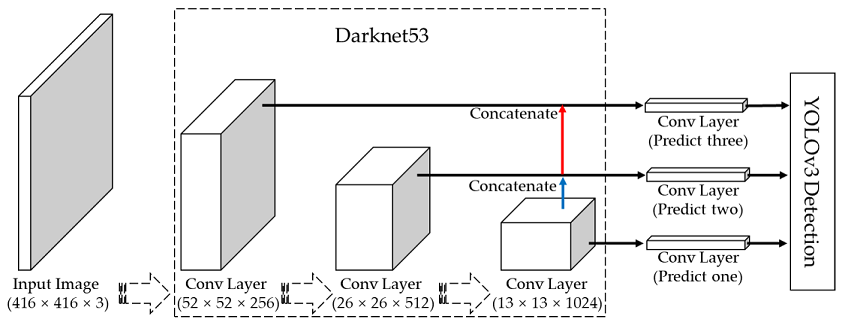

To help the training of such detector, YOLOv3 does the following. Instead of letting the network predict the coordinates of the bounding box from the top-left corner of the image, it only predicts offsets $(t_y, t_x)$ from the top-left corner of the gird cell of the box $(c_y, c_x)$. Since the offsets are in the range $[0, 1]$, it uses sigmoid $\sigma(x)$. Additionally, if the actual box is smaller or bigger, in any direction, than the prior anchor shape $(p_h, p_w)$, the model will predict scaling factors $(t_h, t_w)$. The scale factors can be arbitrarily small or arbitrarily big. Therefore, we will predict them in log-scale (i.e., we need to exponentiate them to retrieve the original scales).

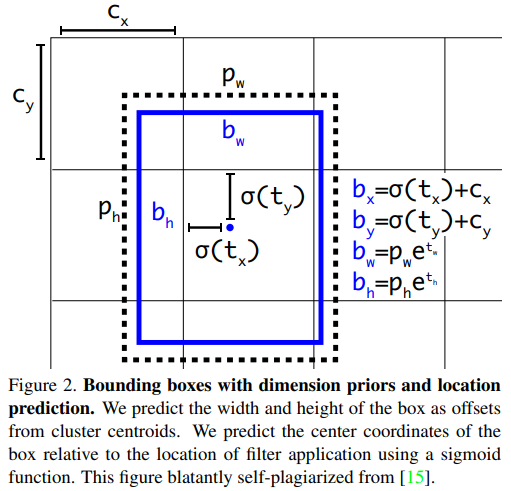

Finally, the last piece of the puzzle that we need to know before building our first detector is what we should do with the predictions. Sometimes, the model will output too many boxes with high confidence scores $p_c$ not because they are wrong but because they have a big overlap (double detection). The way to resolve this is through an algorithm called [non-maximum suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=28 ) ([NMS](http://datahacker.rs/deep-learning-non-max-suppression/)).

Watch [this](https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30) and/or read [this](https://towardsdatascience.com/dive-really-deep-into-yolo-v3-a-beginners-guide-9e3d2666280e) to get a better understanding for all the introduced concepts before we start building YOLOv3.

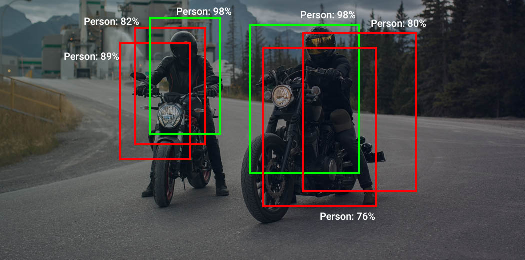

### Feature Extractor (0.25 points)

YOLOv3 uses a backbone feature extractor that is originally an image classifier similar to AlexNet and VGG, called [Darknet-53](https://arxiv.org/abs/1804.02767). It was named this because it has 53 convolutional layers. However, similar to FCN-8s, it has some convolutional layers with $1 \times 1$ kernels (i.e., fully connected (FC/linear) layers in the form of convolutional layers). Here is a summary and an [implementation](https://github.com/developer0hye/PyTorch-Darknet53/blob/master/model.py) of its architecture:

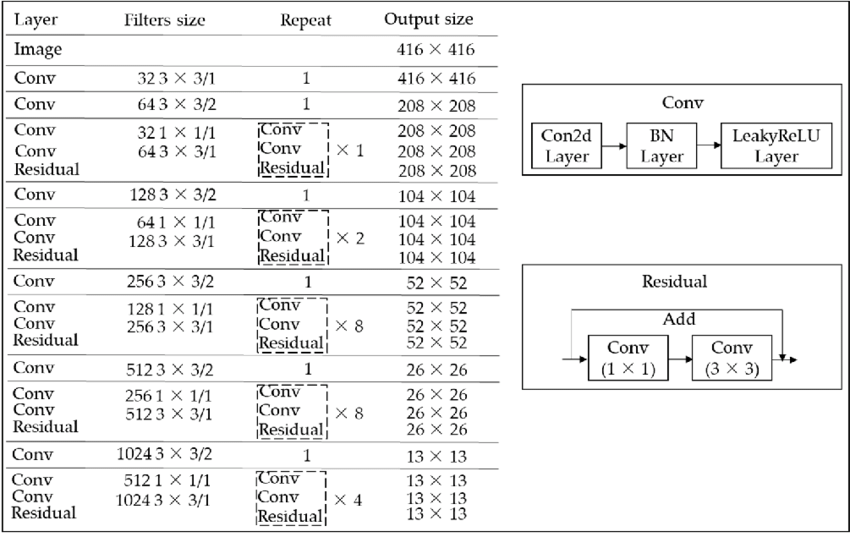

In [21]:
def conv_block(ins, outs, kernel_size=3, stride=1, padding=1):
    """Get default Conv2d-BatchNorm2d-LeakyReLU block for Darknet-53."""
    return nn.Sequential(
        nn.Conv2d(ins, outs, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(outs),
        nn.LeakyReLU(0.1),
    )


class ResidualUnit(nn.Module):
    """Residual unit for Darknet-53."""

    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(channels, channels // 2, kernel_size=1, padding=0),
            conv_block(channels // 2, channels),
        )

    def forward(self, x):
        # TODO: (0.25 points)
        # do the forward pass in one line
#         return torch.cat([self.net(x), x], axis=1) # convolution of the 2 blocks and concatenate residual
        return self.net(x) + x # convolution of the 2 blocks and concatenate residual
        # ^^^^^^^^^^^^^^^^^
    
    # Create a sequential block of multiple ResidualUnit
    @classmethod
    def repeated(cls, channels, times):
        # repeat ResidualUnit multiple times in a comprenhension list
        # unpack (*) comprenhension list into individual args for nn.Sequential container
        return nn.Sequential(*[cls(channels) for _ in range(times)])

def darknet53(in_channels=3):
    """Get Darknet-53 (the feature extractor for YOLOv3)."""
    return nn.Sequential(
        conv_block(in_channels, 32),
        conv_block(32, 64, stride=2),
        ResidualUnit.repeated(64, times=1),
        conv_block(64, 128, stride=2),
        ResidualUnit.repeated(128, times=2),
        conv_block(128, 256, stride=2),
        ResidualUnit.repeated(256, times=8),  # <-- Route 1 (S = I / 8)
        conv_block(256, 512, stride=2),
        ResidualUnit.repeated(512, times=8),  # <-- Route 2 (S = I / 16)
        conv_block(512, 1024, stride=2),
        ResidualUnit.repeated(1024, times=4),  # <-- Route 3 (S = I / 32)
    )
    

### Detection Layers (1.25 points)

Similar to FCN-8s, YOLOv3 takes output features (activation maps) at different stages of its backbone feature extractor and add detection layers on top of them (analogous to the segmentation layers of FCN-8s). The following figure illustrates the building blocks of the entire model.

*Note*: This figure was [made with TensorFlow in mind](http://datahacker.rs/tensorflow2-0-yolov3/) where channels dimension comes last (Batch x Height x Width x Channels).

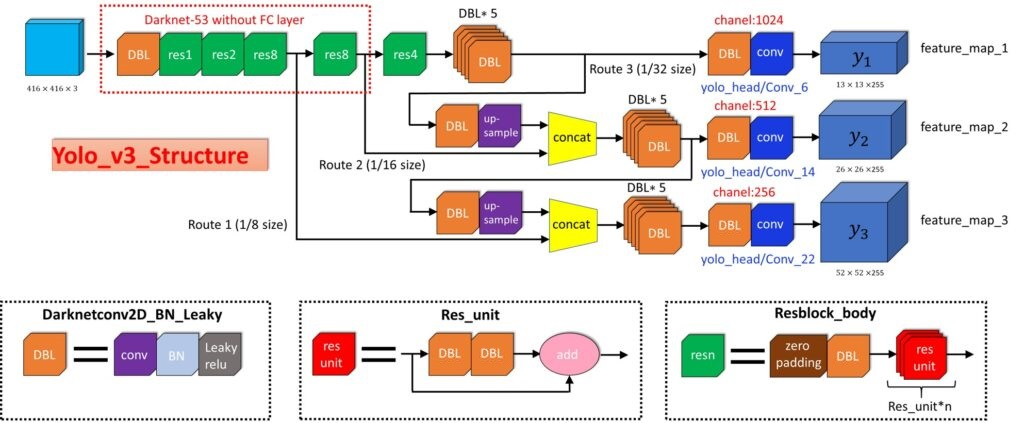

In [22]:
"""
F.interpolate() :  function to upsample or downsample the spatial dimensions of an input tensor
input (Tensor): The input tensor to be resized.
size (int or Tuple[int]): The output size of the tensor.
scale_factor (float or Tuple[float]): The scaling factor to be applied to the tensor.
mode (str): The interpolation mode to be used.'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear', or 'area'.
"""
class ConcatUnit(nn.Module):
    """Concatenation unit for YOLOv3."""
    def __init__(self, in_channels):
        super().__init__()
        out = -(-in_channels // 2)  # ceil(x / n) == -(-x // n)
        self.net = conv_block(in_channels, out, kernel_size=1, padding=0)
        
    def forward(self, x, x_skip):
        # TODO: (0.5 points)
        # do the forward pass (use F.interpolate() to upsample)
        # make sure it has the same height and width of x_skip
#         print(f'x_skip size: {x_skip.shape[2:]}')
        # upsample x using interpolate to have the same height and width of x_skip
        x = self.net(x)
#         print(f'x size: {x.shape[2:]}')
        x = F.interpolate(x, size=x_skip.shape[2:], mode='bilinear', align_corners=True)
        # ^^^^^^^^^^^^^^^^^
        # the concatenation is on the channels dimension
        return torch.cat([x, x_skip], dim=1)

def yolo_block(in_channels, out_channels):
    """Get five convolutional blocks for YOLOv3."""
    mid_channels = out_channels * 2 # define intermetiate channels
    return nn.Sequential( # return five convolutional blocks
        conv_block(in_channels, out_channels, kernel_size=1, padding=0),
        conv_block(out_channels, mid_channels),
        conv_block(mid_channels, out_channels, kernel_size=1, padding=0),
        conv_block(out_channels, mid_channels),
        conv_block(mid_channels, out_channels, kernel_size=1, padding=0),
    )

def yolo_head(in_channels, mid_channels, num_anchors, num_classes):
    """Get a detection head for YOLOv3."""
    # calculate the output channels
    out_channels = (1 + 4 + num_classes) * num_anchors
    # return a detection head
    return nn.Sequential(
        conv_block(in_channels, mid_channels),
        nn.Conv2d(mid_channels, out_channels, kernel_size=1),
    )

class BaseYOLOv3(nn.Module):
    """The base architecture for YOLOv3."""
    def __init__(self, in_channels=3, num_anchors=3, num_classes=80):
        super().__init__()
        self.in_channels = in_channels
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        
        # define the backbone network
        backbone = darknet53(in_channels)
        # split the backbone network into three parts
        self.feature1 = backbone[0:7]
        self.feature2 = backbone[7:9]
        self.feature3 = backbone[9:11]
        
        # define yolo block and head for lagest receptive field
        self.route3 = yolo_block(1024, 512)
        self.head3 = yolo_head(512, 1024, num_anchors, num_classes)

        # define the concatenation unit and yolo block and head for the medium receptive field
        self.concat2 = ConcatUnit(512)
        self.route2 = yolo_block(768, 256)
        self.head2 = yolo_head(256, 512, num_anchors, num_classes)

        # define the concatenation unit and yolo block and head for the smallest receptive field
        self.concat1 = ConcatUnit(256)
        self.route1 = yolo_block(384, 128)
        self.head1 = yolo_head(128, 256, num_anchors, num_classes)
        
        # define a layer to spread the dimensions of the output from the detection head
        self.spread_dim = SpreadDim(1 + 4 + num_classes, dim=1)
        # Note: number of anchors need not to be the same for all scales
        #       but this is how the original YOLOv3 is implemented

    def forward(self, x):
        # compute three features
        r1 = self.feature1(x)
        r2 = self.feature2(r1)
        r3 = self.feature3(r2)

        # TODO: (0.75 points)
        # complete the connections (use the figure above as reference)
        r3 = self.route3(r3)
        r2 = self.route2(self.concat2(r3, r2))
        r1 = self.route1(self.concat1(r2, r1))
        # ^^^^^^^^^^^^^^^^^

        y1 = self.head3(r3)  # large receptive field
        y2 = self.head2(r2)  # medium receptive field
        y3 = self.head1(r1)  # small receptive field

        y1, y2, y3 = map(self.spread_dim, (y1, y2, y3))
        return y1, y2, y3  # return all detection sets

*Note*: to simplify the process of building these models and making modifications to them, we sometimes resort to writing their structure in [configurations files](https://github.com/ultralytics/yolov3/blob/76807fae7104768650d380eaaa9dcb472f7c287d/models/yolov3.yaml) and build them with code that is able to [parse these files](https://github.com/ultralytics/yolov3/blob/76807fae7104768650d380eaaa9dcb472f7c287d/models/yolo.py#L199-L262).

### Final Model (1 point)

We need to add one more thing to our model, which is the prior shapes of the anchors and the appropriate scaling and offsetting of the base model output. Moreover, we will need to perform non-maximum suppression during evaluation. Putting them all together gives us YOLOv3.

In [23]:
class YOLOv3(nn.Module):
    """The YOLOv3 object detector."""
    original_image_size = 416
    anchor_priors = (
        ((116, 90), (156, 198), (373, 326)),
        ((30, 61), (62, 45), (59, 119)),
        ((10, 13), (16, 30), (33, 23)),
    )

    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        # register anchor priors as a buffer to be stored in the model's state
        anchors = torch.FloatTensor(self.anchor_priors)
        self.register_buffer('anchors', anchors)
        
        # instantiate the BaseYOLOv3 model
        self.yolo = BaseYOLOv3(in_channels, len(anchors), num_classes)

    def forward(self, x):
        # forward pass through BaseYOLOv3 to obtain feature maps
        y1, y2, y3 = self.yolo(x)
        a1, a2, a3 = self.anchors # extract the anchor boxes for each feature map

        # compute the bounding boxes for each feature map
        h, w = x.shape[-2:]  # image height and width
        s1, b1, c1 = self.to_bounding_boxes(y1, a1, w, h)  # large boxes
        s2, b2, c2 = self.to_bounding_boxes(y2, a2, w, h)  # medium boxes
        s3, b3, c3 = self.to_bounding_boxes(y3, a3, w, h)  # small boxes

        # concatenate the confidence scores, bounding_boxes, and class logits across the fature maps
        confidence_logits = torch.cat([s1, s2, s3], dim=1)  # shape [B x N]
        bounding_boxes = torch.cat([b1, b2, b3], dim=1)  # shape [B x N x 4]
        classes_logits = torch.cat([c1, c2, c3], dim=1)  # shape [B x N x C]
        return confidence_logits, bounding_boxes, classes_logits

    @torch.no_grad()
    def detect(self, x, iou_threshold=0.6):
        # set the model to evaluation mode
        self.train(False)
        
        # apply non-max supression to the model's output
        nms = self.non_maximum_suppression
        scores, bboxes, labels = nms(*self.forward(x), iou_threshold)
        return scores, bboxes, labels

    @staticmethod
    def to_bounding_boxes(detections, anchors, width, height):
        """Convert the raw output of a YOLOv3 to bounding boxes."""
        # anchors shape: [K x 2]
        # detections shape: [B x (1 + 4 + C) x K x Sy x Sx]
        
        # split the detection tansor into its component parts
        splits = (1, 1, 1, 1, 1, detections.shape[1] - 5) # how the tensor should be split
        scores, t_x, t_y, t_w, t_h, logits = detections.split(splits, dim=1)
        
        # extract the scores, x and y offests, widths and heights, and logits
        # from the detection tensor
        # don't apply sigmoid here (leave it to the loss function)
        scores = scores.flatten(1)  # shape [B x (1 * K * Sy * Sx)]

        s_y, s_x = detections.shape[-2:] # get the height and width of the detection tensor
        # create a grid of x and y coordinates
        c_y, c_x = torch.meshgrid(
            torch.arange(s_y, dtype=t_y.dtype, device=t_y.device),
            torch.arange(s_x, dtype=t_x.dtype, device=t_x.device),
        )
        # get the width and height of the anchor boxes
        p_w, p_h = anchors.T[..., None, None]  # shape [2 x K x 1 x 1]
        # TODO: (0.5 points)
        # Understand these lines
        # calculate the center coordinates and dimensions of the bounding boxes
        # t_x, t_y are offests of the center of bboxes relative to the center of the cell
        # c_x, c_y represent the center of the grid cell
        # s_x, s_y are the width and height of the feature map
        # use sigmoid to ensure that the predicted offsts are in [0,1] range
        b_x = (t_x.sigmoid() + c_x) * (1 / s_x)
        b_y = (t_y.sigmoid() + c_y) * (1 / s_y)
        # b_w and b_h represent the width and height of the pred bboxes
        # exp() to get the original scale t_w, and t_h
        # p_w and p_h are the width and height of the anchor boxes for each cell
        b_w = t_w.exp() * (p_w / width)
        b_h = t_h.exp() * (p_h / height)
        
        # stack the center coordinates and dimensions of the bounding boxes
        # into a single tensor and flatten it
        # flatten to reshape in a 2D tensor, each row represent a bbox
        bboxes = torch.stack([b_x, b_y, b_w, b_h], dim=-1).flatten(1, -2) # dim=-1, concatnate along last dim
        # Note: it is more convenient to work with xyxy format than cxcywh
        #       bboxes operations in torchvision.ops.* use xyxy by default
        #       we can change it to [b_x, b_y, b_x + b_w, b_y + b_h]
        #       but we will keep using cxcywh to follow the official source
        # ^^^^^^^^^^^^^^^^^

        # don't apply softmax here (leave it to the loss function)
        # flatten the logits tensor and transpose it
        logits = logits.flatten(2).transpose(1, 2)  # [B x (K * Sy * Sx) x C]
        return scores, bboxes, logits

    @staticmethod
    def non_maximum_suppression(scores, bboxes, logits, iou_threshold=0.6):
        """Apply NMS on a batch and sort the bboxes by adjusted scores."""
        outputs = zip(*[
            YOLOv3.nms_single_image(*results, iou_threshold)
            for results in zip(scores, bboxes, logits)
        ])
        pad = lambda x: nn.utils.rnn.pad_sequence(x, batch_first=True) # pad remaining bboxes and labels
        adjusted_scores, remaining_bboxes, labels = map(pad, outputs)
        return adjusted_scores, remaining_bboxes, labels

    @staticmethod
    def nms_single_image(scores, bboxes, logits, iou_threshold=0.6):
        """Apply NMS on a single image and sort by adjusted scores."""
        nms = torchvision.ops.batched_nms
        box_convert = torchvision.ops.box_convert # convert bboxes coordinates
        max_probs, labels = logits.softmax(dim=1).max(dim=1) # find probabilities and find maximum probability
        adjusted_scores = max_probs * scores.sigmoid() # multiply mas_probabilities with detection scores
        bboxes = box_convert(bboxes, 'cxcywh', 'xyxy') # from center-coord to top-left, botton-right coord
        indices = nms(bboxes, adjusted_scores, labels, iou_threshold) # perform non-max supression
        # return the indices of the survive after supression
        bboxes = box_convert(bboxes[indices], 'xyxy', 'cxcywh') # convert to center-coord back
        return adjusted_scores[indices], bboxes, labels[indices]

In [24]:
# TODO: (0.5 points)
# you should be able to explain these tensors, their shapes, and dtypes
@torch.no_grad()
def test_yolo(batch_size=2, channels=3, size=416, train=False):
    yolo = YOLOv3().train(train)

    print('Input images:')
    batch = torch.randn(batch_size, channels, size, size)
    print(batch.shape, '\n')

    print('Base yolo:')
    y1, y2, y3 = yolo.yolo(batch)
    print(y1.shape, y2.shape, y3.shape, '\n')

    print('Raw detections:')
    scores, bboxes, logits = yolo(batch)
    print(scores.shape, bboxes.shape, logits.shape, '\n')

    print('Detections after NMS:')
    adjusted_scores, bboxes, labels = yolo.detect(batch)
    print(adjusted_scores.shape, bboxes.shape, labels.shape, '\n')
# ^^^^^^^^^^^^^^^^^

"""
Input images:
    torch.Size([2, 3, 416, 416])
    Batch of 2 RGB images of (416 x 416) pixels

Base yolo:
    (4 + 1 + C)*K
    # per detection whe have 3 anchor boxes, and the final number of predictions
    # is (4 + 1 + C) per bounding box. for this cas C = 80
    torch.Size([2, 85, 3, 13, 13]) : Detections of large receptive field
    torch.Size([2, 85, 3, 26, 26]) : Detections of meidum receptive field
    torch.Size([2, 85, 3, 52, 52]) : Detections of small receptive field
    
    
Raw detections:
    torch.Size([2, 10647]) # per image 10647 
    torch.Size([2, 10647, 4]) # per image 10647 bbox detection, each bbox with 4 elements
    torch.Size([2, 10647, 80]) : per image 10647 probabilities of 80 classes

Detections after NMS:
    torch.Size([2, 8522]) : per image, 8522 scores
    torch.Size([2, 8522, 4]) : per image 8522 bboxes, each box with 4 elements
    torch.Size([2, 8522]) : per image 8522 labels
"""
test_yolo()

Input images:
torch.Size([2, 3, 416, 416]) 

Base yolo:
torch.Size([2, 85, 3, 13, 13]) torch.Size([2, 85, 3, 26, 26]) torch.Size([2, 85, 3, 52, 52]) 

Raw detections:
torch.Size([2, 10647]) torch.Size([2, 10647, 4]) torch.Size([2, 10647, 80]) 

Detections after NMS:
torch.Size([2, 10014]) torch.Size([2, 10014, 4]) torch.Size([2, 10014]) 



Let's define a function to load the weights of a pretrained YOLOv3 model on [COCO dataset](https://github.com/pjreddie/darknet/blob/c6afc7ff1499fbbe64069e1843d7929bd7ae2eaa/data/coco.names) using the [official format](https://github.com/pjreddie/darknet/blob/4a03d405982aa1e1e911eac42b0ffce29cc8c8ef/src/parser.c#L1007-L1083) similar to [this](https://towardsdatascience.com/yolo-v3-object-detection-with-keras-461d2cfccef6) and [this](https://github.com/eriklindernoren/PyTorch-YOLOv3).

In [25]:
coco_classes = (
    'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant',
    'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
)

def load_yolov3_weights(model, weights_path=None):
    # use a default path
    if weights_path is None:
        hub_dir = Path(torch.hub.get_dir())
        weights_path = hub_dir / 'checkpoints/yolov3.weights'

    # download the weights file if it doesn't exist
    weights_path = Path(weights_path)
    if not weights_path.exists():
        url = 'https://pjreddie.com/media/files/yolov3.weights'
        md5 = 'c84e5b99d0e52cd466ae710cadf6d84c'
        download_url(url, weights_path.parent, weights_path.name, md5)

    with open(weights_path, 'rb') as weights_file:
        # start by reading the header (version + num_training_images)
        np.fromfile(weights_file, np.int32, count=3)  # major, minor, revision
        np.fromfile(weights_file, np.int64, count=1)  # num_training_images

        # then read the rest of the weights as np.float32 values
        def read(layer, *parameters):  # order of parameters is important
            for parameter_name in parameters:
                tensor = getattr(layer, parameter_name).data
                raw = np.fromfile(weights_file, np.float32, tensor.numel())
                tensor.copy_(torch.from_numpy(raw).to(tensor).view_as(tensor))

        # in the file, BN weights are saved before Conv weights
        heads = []
        for layer in model.modules():
            if isinstance(layer, nn.Conv2d):
                heads.append(layer)  # keep it for after reading BN weights
                if layer.bias is not None:  # last Conv in yolo_head has bias
                    # if the number of classes is not 80 (COCO Dataset)
                    if layer.out_channels != (1 + 4 + 80) * 3:
                        # create a dummy layer to skip this layer
                        layer = nn.Conv2d(layer.in_channels, 255, 1)
                        heads.pop()
                    read(layer, 'bias', 'weight')
            elif isinstance(layer, nn.BatchNorm2d):
                read(layer, 'bias', 'weight', 'running_mean', 'running_var')
                read(heads.pop(), 'weight')  # every BN has a Conv behind it

        # organize the channel dimension for the heads from
        # the original order to ours K x (4 + 1 + C) -> (1 + 4 + C) x K
        if heads:
            indices = torch.arange(255).view(3, 4 + 1 + 80).t()
            bboxes, scores, classes = indices.split((4, 1, 80))
            order = torch.cat([scores, bboxes, classes]).flatten()
            for layer in heads:
                layer.weight.data.copy_(layer.weight.data[order])
                layer.bias.data.copy_(layer.bias.data[order])
    return model

We will test it out using an image from a given URL (provide your own if you want):

<ipython-input-19-54a53f07d6bf>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_colors) # get color map and number of colors


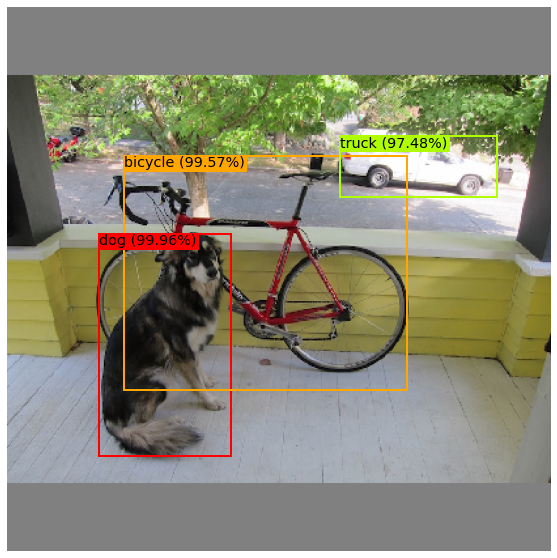

In [26]:
url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg'
image = Image.open(urlopen(url) if url.startswith('http') else url)
image = square_image(image, size=416, color=[128]*3)  # not necessary
images = TF.to_tensor(image).unsqueeze(0).cuda(0)

model = load_yolov3_weights(YOLOv3()).to(images.device)
for image, scores, bboxes, labels in zip(images, *model.detect(images)):
    valid = scores > 0.9  # show boxes above a threshold confidence
    labels = [
        f'{coco_classes[label]} ({score.item() * 100:.2f}%)'
        for score, label in zip(scores[valid], labels[valid])
    ]
    plot_image_with_boxes(image, bboxes[valid], labels)

### Loss function (0.75 points)

To train YOLOv3, we will need to convert the ground truth boxes into the same format as the YOLOv3's output. Once they match, we have a multi-task loss (a term for each output of the network):
$$\mathcal{L}_\text{YOLOv3} = \mathcal{L}_\text{objecteness} + \mathcal{L}_\text{boxes} + \mathcal{L}_\text{classes}$$

The [details of each term](https://stats.stackexchange.com/q/373266) varies between implementations we can adopt [many tricks](https://github.com/ultralytics/yolov3/blob/master/utils/loss.py) like [this](https://www.reddit.com/r/computervision/comments/2ggc5l/what_is_hard_negative_mining_and_how_is_it/ckiuu9i/) but we are going with the following:

- $\mathcal{L}_\text{classes}$: softmax cross-entropy loss or binary cross-entropy for multi-label classification or hierarchical classes (e.g., woman and person)
- $\mathcal{L}_\text{boxes}$: MSE loss on square roots or scaled by a factor to make the training fair for small boxes (e.g. $2 - h \times w$)
- $\mathcal{L}_\text{objecteness}$: binary cross-entropy loss but allow close false positives (penalize only the ones with low $\text{IoU}$)

*Note*: officially, $\mathcal{L}_\text{boxes}$ is computed on the BaseYOLOv3 model but we will compute it on the final model in log-space instead for simplicity.

In [27]:
class CustomYOLOv3Loss(nn.Module):
    def __init__(self, image_size, anchors, ignore_iou=0.5):
        super().__init__()
        self.image_size = image_size  # image_size assuming width == height
        self.ignore_iou = ignore_iou

        # for images of size 416 -> detection set sizes are [13, 26, 52]
        sizes = torch.FloatTensor([1 / 32, 1 / 16, 1 / 8]) * self.image_size
        self.register_buffer('set_size', sizes.long())

        # anchors [D x K x 2] (D is the number of detection sets)
        self.register_buffer('anchors', torch.as_tensor(anchors).float())

        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='none')
        self.sce = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, pred, true):
        p_score, p_bbox, p_logit = pred  # output of YOLOv3.forward()
        b_bbox, b_label = true  # ground truth in batch format
        t_bbox, t_label = self.convert_to_yolo_format(b_bbox, b_label)

        # we only really care about actual true boxes
        # but we need to ignore boxes with high IoU (close false positives)
        true_box = t_label >= 0
        high_iou = self.best_iou(p_bbox.data, b_bbox) > self.ignore_iou
        false_box = ~(true_box | high_iou)

        # compute the objectness loss term using binary cross entropy
        p_score_true, p_score_false = p_score[true_box], p_score[false_box]
        loss_obj = self.bce(p_score_true, torch.ones_like(p_score_true))
        loss_no_obj = self.bce(p_score_false, torch.zeros_like(p_score_false))

        # compute the loss term for the bounding boxes
        p_bbox_xy, p_bbox_wh = p_bbox[true_box].split(2, dim=-1)
        t_bbox_xy, t_bbox_wh = t_bbox[true_box].split(2, dim=-1)
        loss_xy = self.mse(p_bbox_xy, t_bbox_xy).sum(dim=-1)
        loss_wh = self.mse(p_bbox_wh.log(), t_bbox_wh.log()).sum(dim=-1)
        # TODO: (0.5 points)
        # compute the scaling factor to account for small boxes
        # we could have used mse(sqrt(log(x + 1)), sqrt(log(y + 1)))
        # for loss_wh which is closer to the loss described in YOLOv1
        factor = (2.0 - (t_bbox_wh[:, 0] * t_bbox_wh[:, 1]))#/self.image_size
#         print(factor)
        loss_xy = (factor * loss_xy).sum()
        loss_wh = (factor * loss_wh).sum()
        loss_box = loss_xy + loss_wh
        # ^^^^^^^^^^^^^^^^^

        # compute the classes loss term using softmax cross-entropy
        loss_cls = self.sce(p_logit[true_box], t_label[true_box])

        # uncomment this for quick debugging
        # loss_terms = (loss_obj, loss_no_obj, loss_xy, loss_wh, loss_cls)
        # print([float(x) for x in loss_terms])

        # the coefficients are from YOLOv1 altough it is not the same loss
        # change them if you want but we are sticking with them for now
#         return loss_obj + 0.5 * loss_no_obj + 5 * loss_box + loss_cls
        return loss_obj + 0.5 * loss_no_obj + 1 * loss_box + loss_cls

    @staticmethod
    def best_iou(pred, true):
        """Get maximum IoU between every predicted box and any true box."""
        iou = torchvision.ops.box_iou
        convert = torchvision.ops.box_convert
        pred = convert(pred.flatten(0, -2), 'cxcywh', 'xyxy').view_as(pred)
        true = convert(true.flatten(0, -2), 'cxcywh', 'xyxy').view_as(true)
        return torch.stack([  # batch items must be independent
            iou(*x).max(dim=1).values for x in zip(pred, true)
        ])

    def convert_to_yolo_format(self, bboxes, labels):
        """Convert a detection data target batch to YOLOv3 output format."""
        # bboxes [Batch x M x 4] (M is max_num_objects)
        # labels [Batch x M] the values are in [-1, C)
#         print(f'bboxes: {bboxes.shape}')
#         print(f'labels: {labels.shape}')
        
        # create output placeholders
        batch_size = len(labels)
        all_bboxes = self.anchors.shape[1] * self.set_size.pow(2).sum() # calculate the number of bboxes
        out_bboxes = torch.zeros(batch_size, all_bboxes, 4).to(bboxes)
        out_labels = torch.full((batch_size, all_bboxes), -1).to(labels)

        # for every true bounding box, find the closest anchor
        flat_anchors = self.anchors.flatten(0, 1) / self.image_size
        # originally, the closest is the one with max intersection area
        closest = torch.min(  # argmax(min_width * min_height)
            bboxes[..., -2:].unsqueeze(-2), flat_anchors
        ).prod(dim=-1).argmax(dim=-1)
        # maybe we can use argmin(sqrt(width_diff^2 + height_diff^2)) instead
        # closest = torch.cdist(bboxes[..., -2:], flat_anchors).argmin(dim=-1)
        set_index = closest // self.anchors.shape[1]  # detection set index
        anchor_index = closest % self.anchors.shape[1]  # np.unravel_index

        # get the cell position in the grid (c_x, c_y)
        size = self.set_size[set_index]  # S values as [Batch x M]
        c_x, c_y = (size * bboxes[..., :2].permute(2, 0, 1)).long()

        # get the positions (indices) of true boxes w.r.t. output placeholders
        # calculate positions of the true boxes respect to the output placeholders
        # combining anchor index, grid dimensions, and cell positions.
        pos = (anchor_index * size + c_y) * size + c_x  # np.ravel_multi_index

        # fill the output tensors with true boxes
        true_boxes = labels >= 0
        # TODO: (0.25 points)
        # Understand the following
        # Construct tuple containing the indices of true values
        index = (torch.where(true_boxes)[0], pos[true_boxes])
        out_bboxes[index] = bboxes[true_boxes] 
        out_labels[index] = labels[true_boxes]
#         print(f'out_bboxes: {out_bboxes.shape}')
#         print(f'out_labels: {out_labels.shape}')
        # ^^^^^^^^^^^^^^^^^

        # the above is the same as the following but more efficient
        # for i, (position, true) in enumerate(zip(pos, true_boxes)):
        #     out_bboxes[i, position[true]] = bboxes[i, true]
        #     out_labels[i, position[true]] = labels[i, true]

        return out_bboxes, out_labels

This is the end of this project as it has become long enough. We built all the required building blocks for YOLOv3. You can train it on your own.

## Task3: Training and Visualization (0 points)

To train YOLOv3 on our dataset, we need to pick the prior shapes of the anchors that fit it the best. We will be going to use these anchors:

- $y_1$: $(16 \times 27), (21 \times 23), (26 \times 20)$
- $y_2$: $(11 \times 23), (16 \times 20), (21 \times 16)$
- $y_3$: $(6 \times 20), (11 \times 16), (16 \times 12)$

Instead of using k-means clustering, these values were computed heuristically using the mean and standard deviation height and width of the bounding boxes of 10,000 randomly chosen images from our dataset. If you are interested in the details, you can check the following cell:

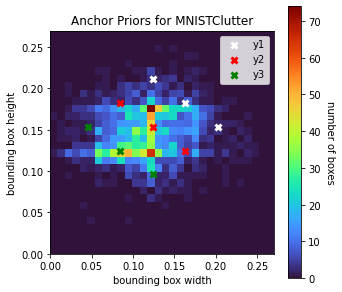

tensor([[[16, 27],
         [21, 23],
         [26, 20]],

        [[11, 23],
         [16, 20],
         [21, 16]],

        [[ 6, 20],
         [11, 16],
         [16, 12]]])


In [28]:
def batched_std_mean(data, unbiased=True):
    """Compute std and mean for a sequence of batches.
    
    when x = torch.randn(1000, 5, 2), then batched_std_mean(x)
    simulates torch.std_mean(x, dim=[0, 1])

    This the same function we use to compute the mean and std pixel values
    of an images dataset for the normalize transform before training.
    Instead of loading all images to memory at once,
    we accumulate them one-by-one or in batches.

    This particular implementation avoids numerical instabilities.
    More: https://gist.github.com/ModarTensai/dc95444faf3624ed979b4d0b2088fdf1
    """
    running_count = 0
    running_mean = 0
    running_mass = 0

    for batch in tqdm(data):
        count = batch.shape[0]
        variance, mean = torch.var_mean(batch, dim=0, unbiased=False)

        mass = mean - running_mean
        running_mean += mass * (count / (running_count + count))
        mass *= mean - running_mean
        if count > 1:
            mass += variance
            mass *= count
        running_mass += mass
        running_count += count

    running_variance = running_mass / (running_count - int(bool(unbiased)))
    return running_variance.sqrt(), running_mean


dataset = MCDetection()
# use this to compute the mean and std height and width bbox 
# box_wh_std, box_wh_mean = batched_std_mean(
#     map(lambda x: x[1][..., -2:][x[2] >= 0], dataset))

# I ran it and got these values for the first 10K images
box_wh_std = torch.FloatTensor([0.0392, 0.0288])
box_wh_mean = torch.FloatTensor([0.1238, 0.1536])

# assuming these sizes form a gaussian blob,
# we pick 9 points forming a 90 degrees rotated lattice
lattice = torch.FloatTensor((
    ((0, 2), (1, 1), (2, 0)),
    ((-1, 1), (0, 0), (1, -1)),
    ((-2, 0), (-1, -1), (0, -2)),
)) * box_wh_std + box_wh_mean

# let's visualize few samples with the chosen anchors
heatmap = 0
xlim, ylim = [0, 0.27], [0, 0.27]
for i, (_, bboxes, labels) in enumerate(dataset):
    if i > 500:  # increase this to see more data
        break
    x, y = bboxes[..., -2:][labels >= 0].T.numpy()
    heatmap += np.histogram2d(x, y, bins=30, range=[xlim, ylim])[0].T

# plot the heatmap along with the anchors
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(heatmap, extent=[*xlim, *ylim], cmap='turbo', origin='lower')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('number of boxes', rotation=-90, va='bottom')
ax.scatter(*lattice[0].T, marker='x', color='w', linewidths=3, label='y1')
ax.scatter(*lattice[1].T, marker='x', color='r', linewidths=3, label='y2')
ax.scatter(*lattice[2].T, marker='x', color='g', linewidths=3, label='y3')
ax.set_xlabel('bounding box width')
ax.set_ylabel('bounding box height')
ax.set_title('Anchor Priors for MNISTClutter')
ax.legend()
plt.show(fig)

mc_anchors = (lattice * dataset.image_size).round().long()
print(mc_anchors)

The next step is to write the training code simply as before. We just need to change the loss and the metrics. The most common metric used for object detection is the mean average precision (mAP). Check [this](https://github.com/Cartucho/mAP) out to know more about it as we will exclude it here.

In [29]:
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()


def one_epoch(phase, model, loader, device, optimizer=None):
    metrics = ClassificationMetrics(num_classes=10)
    image_size = loader.dataset.image_size
    criterion = CustomYOLOv3Loss(image_size, model.anchors, ignore_iou=0.5)
    criterion.to(device)  # important to move the buffers and the parameters
    metrics.num_images = metrics.loss = 0
    training = phase is Phase.TRAINING
    with torch.set_grad_enabled(training):
        model.train(training) # set the model to training if it's configured
        for batch in tqdm(loader):
            images, t_bbox, t_label = map(lambda x: x.to(device), batch)

            pred = p_score, p_bbox, p_logit = model(images)
            true = t_bbox, t_label
            loss = criterion(pred, true)
 
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            metrics.num_images += len(images)
            metrics.loss += loss.item() * len(images)
    metrics.loss /= max(metrics.num_images, 1)
    return metrics

def train(model, train_loader, val_loader, optimizer, device, epochs):
    best_value = 0
    best_state = None
    last_best = 0
    logs = []
    for epoch in range(epochs):
        print(f'Epoch: {epoch}'.ljust(11) + '#' * 42)
        train_metrics = one_epoch(
            Phase.TRAINING,
            model,
            train_loader,
            device,
            optimizer,
        )
        print(f'TRAINING: Loss = {train_metrics.loss}')

        val_metrics = one_epoch(Phase.VALIDATION, model, val_loader, device)
        print(f'VALIDATION: Loss = {val_metrics.loss}')

        logs.append((train_metrics, val_metrics)) 

        current_value = val_metrics.loss
        if current_value >= best_value:
            last_best = 0
            best_value = current_value
            best_state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
            }
        else:
            last_best += 1

        if math.isnan(train_metrics.loss) or math.isinf(train_metrics.loss):
            print('Reached invalid loss! (no point in continuing)')
            break

        print('#' * 53 + '\n')
    return best_state, logs

Then, prepare the data and the model.

In [30]:
torch.manual_seed(0)

# data_splits = random_split(MNISTClutter(), [8000, 1000, 1000])

# to debug, we usually make the model overfit on a subset of the data
# https://pytorch-lightning.readthedocs.io/en/0.4.9/Trainer/debugging/
data_splits = random_split(MNISTClutter(max_num_digits=3), [128, 128, 9744])

# do data loading as usual
train_set, val_set, test_set = map(MCDetection, data_splits)
device = torch.device('cuda:0')
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=device.type == 'cuda',
    drop_last=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=256,
    num_workers=4,
    pin_memory=device.type == 'cuda',
)
test_loader = DataLoader(
    test_set,
    batch_size=256,
    num_workers=4,
    pin_memory=device.type == 'cuda',
)


model = YOLOv3(3, 10).to(device)

# change the anchors to ours
model.anchors.copy_(mc_anchors)

# we will start of with the pretrained model
load_yolov3_weights(model)

# we can freeze only the features extractor
# model.yolo.feature1.requires_grad_(False)
# model.yolo.feature2.requires_grad_(False)
# model.yolo.feature3.requires_grad_(False)

# or freeze everything except for the YOLO heads
model.requires_grad_(False)
model.yolo.head1.requires_grad_(True)
model.yolo.head2.requires_grad_(True)
model.yolo.head3.requires_grad_(True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Next, is the actual training. 

In [31]:
epochs = 100
best, logs = train(model, train_loader, val_loader, optimizer, device, epochs)

Epoch: 0   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 45148.39453125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 50281.53515625
#####################################################

Epoch: 1   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 42938.703125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 41204.859375
#####################################################

Epoch: 2   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 31237.51171875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 36457.64453125
#####################################################

Epoch: 3   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 25589.14453125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 30685.146484375
#####################################################

Epoch: 4   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 21719.783203125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 24031.326171875
#####################################################

Epoch: 5   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 18498.95703125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 18626.986328125
#####################################################

Epoch: 6   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 15680.0322265625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 15107.6826171875
#####################################################

Epoch: 7   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 13302.7490234375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 12951.65625
#####################################################

Epoch: 8   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 11336.3662109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 11491.3115234375
#####################################################

Epoch: 9   ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 9737.47265625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 10320.4541015625
#####################################################

Epoch: 10  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 8443.193359375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 9238.9453125
#####################################################

Epoch: 11  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 7389.28662109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 8174.39501953125
#####################################################

Epoch: 12  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 6523.02099609375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 7096.14892578125
#####################################################

Epoch: 13  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 5801.25


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 6146.0107421875
#####################################################

Epoch: 14  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 5193.5771484375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 5342.69677734375
#####################################################

Epoch: 15  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 4677.63037109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 4656.0146484375
#####################################################

Epoch: 16  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 4236.44384765625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 4139.24560546875
#####################################################

Epoch: 17  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 3855.96533203125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 3729.66015625
#####################################################

Epoch: 18  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 3526.764404296875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 3409.53759765625
#####################################################

Epoch: 19  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 3233.793701171875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 3170.6591796875
#####################################################

Epoch: 20  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2978.095458984375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2990.427734375
#####################################################

Epoch: 21  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2754.762451171875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2855.539794921875
#####################################################

Epoch: 22  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2543.139404296875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2752.141845703125
#####################################################

Epoch: 23  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2361.0986328125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2668.048828125
#####################################################

Epoch: 24  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2199.709228515625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2593.16455078125
#####################################################

Epoch: 25  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 2056.139404296875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2526.5390625
#####################################################

Epoch: 26  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1930.5653076171875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2465.88330078125
#####################################################

Epoch: 27  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1813.91845703125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2415.225830078125
#####################################################

Epoch: 28  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1710.87158203125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2365.795166015625
#####################################################

Epoch: 29  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1617.537109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2317.042724609375
#####################################################

Epoch: 30  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1533.194091796875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2269.94384765625
#####################################################

Epoch: 31  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1454.4898681640625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2226.79833984375
#####################################################

Epoch: 32  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1382.8677978515625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2187.183349609375
#####################################################

Epoch: 33  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1317.1668701171875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2147.88623046875
#####################################################

Epoch: 34  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1256.690673828125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2111.591552734375
#####################################################

Epoch: 35  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1201.44580078125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2076.0654296875
#####################################################

Epoch: 36  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1149.911865234375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2047.872802734375
#####################################################

Epoch: 37  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1102.559814453125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 2021.3465576171875
#####################################################

Epoch: 38  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1058.3966064453125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1999.433837890625
#####################################################

Epoch: 39  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 1017.3343505859375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1980.8204345703125
#####################################################

Epoch: 40  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 983.0725708007812


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1965.30078125
#####################################################

Epoch: 41  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 947.4490966796875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1951.142333984375
#####################################################

Epoch: 42  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 914.020263671875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1939.1279296875
#####################################################

Epoch: 43  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 882.1885375976562


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1926.8304443359375
#####################################################

Epoch: 44  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 848.8886108398438


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1916.922119140625
#####################################################

Epoch: 45  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 820.8048095703125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1907.18212890625
#####################################################

Epoch: 46  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 794.656494140625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1899.2559814453125
#####################################################

Epoch: 47  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 771.1728515625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1890.256103515625
#####################################################

Epoch: 48  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 746.4342041015625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1881.52783203125
#####################################################

Epoch: 49  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 724.8253784179688


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1873.31640625
#####################################################

Epoch: 50  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 718.738037109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1865.1668701171875
#####################################################

Epoch: 51  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 683.2026977539062


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1857.787353515625
#####################################################

Epoch: 52  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 663.804931640625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1850.54541015625
#####################################################

Epoch: 53  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 645.225830078125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1844.369140625
#####################################################

Epoch: 54  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 627.894775390625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1838.2384033203125
#####################################################

Epoch: 55  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 610.7931518554688


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1833.498291015625
#####################################################

Epoch: 56  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 602.6071166992188


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1828.5858154296875
#####################################################

Epoch: 57  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 578.7764282226562


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1826.458251953125
#####################################################

Epoch: 58  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 563.9498901367188


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1824.230712890625
#####################################################

Epoch: 59  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 549.965087890625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1821.7294921875
#####################################################

Epoch: 60  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 536.3257446289062


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1821.0048828125
#####################################################

Epoch: 61  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 523.35546875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1821.5146484375
#####################################################

Epoch: 62  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 514.21533203125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1821.95458984375
#####################################################

Epoch: 63  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 498.675537109375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1823.3670654296875
#####################################################

Epoch: 64  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 486.8823547363281


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1824.80712890625
#####################################################

Epoch: 65  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 475.830322265625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1827.31494140625
#####################################################

Epoch: 66  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 465.11090087890625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1830.0169677734375
#####################################################

Epoch: 67  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 459.3699035644531


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1833.630126953125
#####################################################

Epoch: 68  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 445.1406555175781


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1836.487548828125
#####################################################

Epoch: 69  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 435.77117919921875


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1839.381103515625
#####################################################

Epoch: 70  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 426.5419006347656


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1841.7496337890625
#####################################################

Epoch: 71  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 417.84710693359375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1845.266845703125
#####################################################

Epoch: 72  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 413.17193603515625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1847.4920654296875
#####################################################

Epoch: 73  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 401.37103271484375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1849.206787109375
#####################################################

Epoch: 74  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 393.757568359375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1851.628662109375
#####################################################

Epoch: 75  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 388.8558044433594


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1853.27099609375
#####################################################

Epoch: 76  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 379.0232238769531


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1854.966064453125
#####################################################

Epoch: 77  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 373.7642517089844


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1857.38818359375
#####################################################

Epoch: 78  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 365.8020324707031


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1858.999267578125
#####################################################

Epoch: 79  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 359.6325378417969


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1860.4864501953125
#####################################################

Epoch: 80  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 353.7646484375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1861.781982421875
#####################################################

Epoch: 81  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 347.64947509765625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1863.12255859375
#####################################################

Epoch: 82  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 341.5612487792969


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1864.8494873046875
#####################################################

Epoch: 83  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 335.80401611328125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1866.74755859375
#####################################################

Epoch: 84  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 330.31243896484375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1868.787353515625
#####################################################

Epoch: 85  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 331.20660400390625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1871.6053466796875
#####################################################

Epoch: 86  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 325.46539306640625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1874.376953125
#####################################################

Epoch: 87  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 314.8226623535156


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1877.275146484375
#####################################################

Epoch: 88  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 309.89068603515625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1880.95166015625
#####################################################

Epoch: 89  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 305.3419494628906


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1884.123046875
#####################################################

Epoch: 90  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 300.9342956542969


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1888.009765625
#####################################################

Epoch: 91  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 301.05841064453125


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1890.53271484375
#####################################################

Epoch: 92  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 292.80267333984375


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1892.7724609375
#####################################################

Epoch: 93  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 288.2820739746094


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1894.782470703125
#####################################################

Epoch: 94  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 291.1739196777344


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1896.702392578125
#####################################################

Epoch: 95  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 280.2425231933594


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1898.550537109375
#####################################################

Epoch: 96  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 278.9509582519531


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1899.378662109375
#####################################################

Epoch: 97  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 274.6347351074219


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1899.775634765625
#####################################################

Epoch: 98  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 269.26025390625


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1900.17822265625
#####################################################

Epoch: 99  ##########################################


  0%|          | 0/1 [00:00<?, ?it/s]

TRAINING: Loss = 266.1499938964844


  0%|          | 0/1 [00:00<?, ?it/s]

VALIDATION: Loss = 1901.4622802734375
#####################################################



Once you are done, you can visualize few examples from the dataset (pick which split).

<ipython-input-19-54a53f07d6bf>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', num_colors) # get color map and number of colors


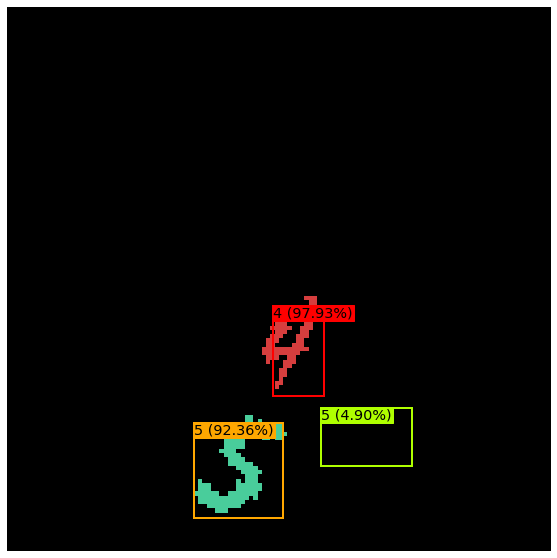

In [35]:
count = 1
data_split = train_set

indices = torch.randint(len(data_split), [count])
batch = test_loader.collate_fn([data_split[i] for i in indices])
images, t_bboxes, t_labels = map(lambda x: x.to(device), batch)
for image, scores, bboxes, labels in zip(images, *model.detect(images)):
#     valid = scores > 0.9 # show boxes above a threshold confidence
    valid = scores > scores[3]  # get the top-k boxes
    labels = [
        f'{label} ({score.item() * 100:.2f}%)'
        for score, label in zip(scores[valid], labels[valid])
    ]
    plot_image_with_boxes(image, bboxes[valid], labels)

## Designing Attention Blocks for Vision Transformer 


Multi-Head Attention is a fundamental mechanism in the Transformer architecture, which has revolutionized natural language processing tasks such as machine translation, text summarization, and question answering. At a high level, it enables the model to focus on different parts of the input sequence at the same time, by computing attention scores in parallel across multiple "heads".

To achieve this, the input sequence is first transformed into three vectors: the query vector, the key vector, and the value vector. These vectors are then used to compute attention scores between each position in the input sequence. The attention scores for each position are normalized across all positions, creating a probability distribution that determines the importance of each position. The value vectors are then combined using the attention scores to produce a weighted sum, which forms the output of the Multi-Head Attention layer.

By allowing the model to attend to multiple parts of the input sequence at once, Multi-Head Attention enables the model to capture complex relationships between words and their context. This is particularly useful for tasks such as machine translation, where the model needs to understand the meaning of the entire sentence in order to generate an accurate translation. Additionally, by computing attention scores in parallel across multiple heads, Multi-Head Attention improves the model's ability to learn from diverse patterns in the data and makes it more robust to noisy inputs.

Please Check Out this [Post](https://jalammar.github.io/illustrated-transformer/) for more details. DO READ THIS REFERENCE! Or check out the [video](https://www.youtube.com/watch?v=-QH8fRhqFHM&embeds_euri=https%3A%2F%2Fjalammar.github.io%2F&source_ve_path=MjM4NTE&feature=emb_title).

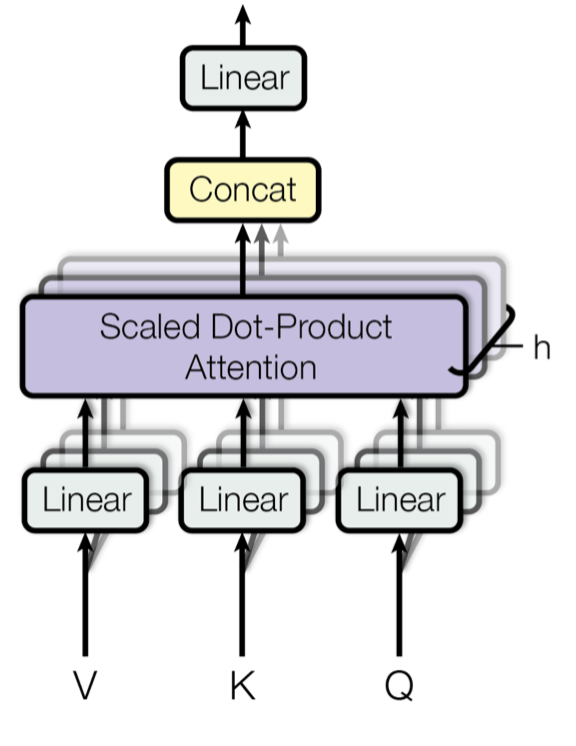


In assignment 1, we coded up the preprocessing step needed in vision transformers. We will adopt the Pre-Layer Normalization Transformer blocks introduced by Ruibin Xiong and colleagues in 2020. Unlike the traditional approach of applying Layer Normalization between residual blocks, the Pre-LN version incorporates Layer Normalization as the first layer in the residual blocks. This modification improves the flow of gradients and eliminates the need for a warm-up phase. Refer to the visualization below for a comparison between the standard Post-LN and Pre-LN versions. [reference](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)



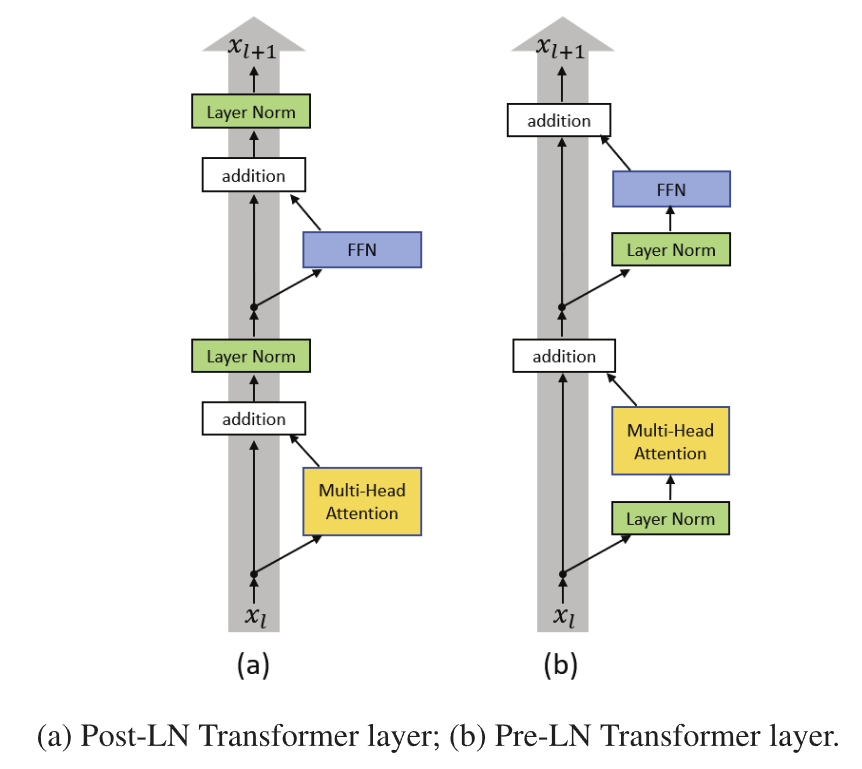

In [33]:
class AttentionBlock(nn.Module):
    
    # The figure above shows Post-LN Transformer Layer and Pre-LN Transformer Layer.
    # # We will need to implement those in the forward pass of the AttentionBlock class below.
      
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.LN1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.LN2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        '''
        TODO: Implement Post-LN and Pre-LN Attention Block Forward Passes
        You can comment out one and keep the other to keep them in the same forward function.
        Write a comment above each specifying whether it is pre or post LN.
        '''
        # Pre-LN
        # first block
        x_b1 = self.LN1(x)
        x_b1 = self.attn(x_b1)
        x = x + x_b1 # addition
        
        # Second block
        x_b2 = self.LN2(x)
        x_b2 = self.linear(x_b2)
        x = x + x_b2
        
        # Post-LN
#         # first block
#         x_b1 = self.attn(x)
#         x = x + x_b1
#         x = self.LN1(x)
        
#         # second block
#         x_b2 = self.linear(x)
#         x = x + x_b2
#         x = self.LN2(x)

        return x